In [1]:
import sys
import os
import time
import numpy as np
import numpy.fft as fourier
import math
import time

from gurobipy import *

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline


def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(np.flipud(np.transpose(img0)))
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(np.flipud(np.transpose(img1)))
    sub1.set_title(title1)


In [2]:
def convolve2d_cutoff(D, psf):
    psf = np.flipud(np.fliplr(psf))
    convolve = np.zeros(dirty_map.shape)
    XC = int(math.floor(psf.shape[0]/2 -1))
    YC = int(math.floor(psf.shape[1]/2 -1))
    norm = psf.sum()
    for x in range(0, dirty_map.shape[0]):
        for y in range(0, dirty_map.shape[1]):
            s = 0
            for i in range(0, psf_map.shape[0]):
                for j in range(0, psf_map.shape[1]):
                    xInd = (x + i - XC)
                    yInd = (y + j - YC)
                    if xInd >= 0 and xInd < dirty_map.shape[0] and yInd >= 0 and yInd < dirty_map.shape[1]:
                        s += psf[i, j] * D[xInd,yInd]
            convolve[x,y] = s
    return convolve

def convolve2d_circular(D, psf):
    psf = np.flipud(np.fliplr(psf))
    convolve = np.zeros(dirty_map.shape)
    XC = int(math.floor(psf.shape[0]/2 -1))
    YC = int(math.floor(psf.shape[1]/2 -1))
    norm = psf.sum()
    for x in range(0, dirty_map.shape[0]):
        for y in range(0, dirty_map.shape[1]):
            s = 0
            for i in range(0, psf_map.shape[0]):
                for j in range(0, psf_map.shape[1]):
                    xInd = (x + i - XC) % psf_map.shape[0]
                    yInd = (y + j - YC) % psf_map.shape[1]
                    s += psf[i, j] * D[xInd,yInd]
            convolve[x,y] = s
    return convolve

def makeGaussian(size, fwhm = 3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

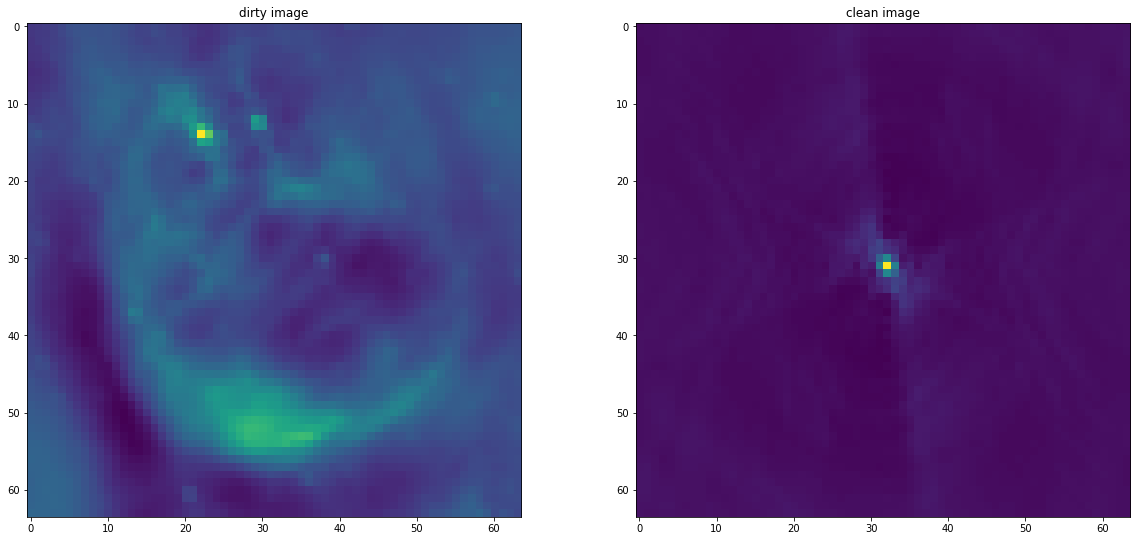

In [23]:
#folder = "./img-csv/test_64.64/"
#folder = "./img-csv/sun.flare00_64.64/"
#folder = "./img-csv/sun.center00_128.128/"
folder = "./img-csv/nova00_128.128/"

dirty_map = np.genfromtxt(folder+'dirty.csv', delimiter=',') [32:96,32:96]
psf_map = np.genfromtxt(folder+'psf.csv', delimiter=',') [32:96,32:96]
clean_map = np.genfromtxt(folder+'clean.csv', delimiter=',') [32:96,32:96]
model_map = np.genfromtxt(folder+'model.csv', delimiter=',') [32:96,32:96]

plot_comparison(dirty_map, 'dirty image', psf_map, 'clean image')

***

## Dirty Map Reconstruction with gurobi

$minimize \left \| D_b - x \right \|_2^2$

In [540]:
dirty_flat = dirty_map.flatten()
m = Model("dirty-reconstruction")

x0 = []
for i in range(0, dirty_flat.size):
    x0.append(m.addVar(lb=-GRB.INFINITY))
    
obj = QuadExpr()
for i in range(0, dirty_flat.size):
    obj += (x0[i] - dirty_flat[i])*(x0[i] - dirty_flat[i])

m.setObjective(obj, GRB.MINIMIZE)
m.optimize()  

reconstruction = np.reshape([var.x for var in m.getVars()], dirty_map.shape)
del m
del obj

Optimize a model with 0 rows, 4096 columns and 0 nonzeros
Model has 4096 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e-03, 6e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 4096 columns
Presolve time: 0.04s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.04 seconds
Optimal objective 1.33383082e-09


In [ ]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "reconstruction")

***
## Reconstruction with PSF in Fourier Space ~ CLEAN

$minimize \left \| fft(D_b) - fft(x) * fft(PSF) \right \|_2^2$

In [54]:
D_FT = fourier.fftshift(fourier.fft2(dirty_map))
D_real = np.real(D_FT)
D_imag = np.imag(D_FT)

#cut most of the psf
#psf = np.zeros(psf_map.shape)
#cut = int(psf_map.shape[0]/4)
#psf[cut:3*cut, cut:3*cut] = psf_map[cut:3*cut, cut:3*cut]

PSF_FT = fourier.fftshift(fourier.fft2(psf_map))
PSF_real = np.real(PSF_FT)
PSF_imag = np.imag(PSF_FT)

In [61]:
model = Model("dirty-psf")

x0_real = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
x0_imag = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)

objective = QuadExpr()
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        objective += (D_real[i, j]- (x0_real[i, j] * PSF_real[i, j] - x0_imag[i, j] * PSF_imag[i, j])) * (D_real[i, j]- (x0_real[i, j] * PSF_real[i, j] - x0_imag[i, j] * PSF_imag[i, j]))
        objective += (D_imag[i, j] - (x0_real[i, j] * PSF_imag[i, j] + x0_imag[i,j] * PSF_real[i,j])) * (D_imag[i, j] - (x0_real[i, j] * PSF_imag[i, j] + x0_imag[i,j] * PSF_real[i,j]))
        #objective += (x0_real[i, j] * PSF_real[i, j] - D_real[i, j]) * (x0_real[i, j] * PSF_real[i, j] - D_real[i, j]) #real part
        #objective += (x0_imag[i, j] * PSF_imag[i, j] -D_imag[i, j]) * (x0_imag[i, j] * PSF_imag[i, j] - D_imag[i, j]) #imaginary part

model.setObjective(objective, GRB.MINIMIZE)
model.optimize() 

FT_rec = np.zeros(dirty_map.shape, dtype=np.complex128)
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        FT_rec[i, j] = x0_real[i, j].x + x0_imag[i, j].x * 1j


reconstruction = fourier.ifft2(fourier.ifftshift(FT_rec)).real
m, n = reconstruction.shape
reconstruction = np.roll(reconstruction, int(-m/2),axis=0)
reconstruction = np.roll(reconstruction, int(-n/2),axis=1)
del model
del objective

Optimize a model with 0 rows, 8192 columns and 0 nonzeros
Model has 8192 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e-05, 7e+05]
  QObjective range [1e-04, 6e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 8192 columns
Presolve time: 0.03s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.04 seconds
Optimal objective 6.75611264e-07


In [ ]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "fft reconstruction")

In [63]:
convolve = convolve2d_circular(reconstruction, psf_map)

In [ ]:
plot_comparison(dirty_map, 'dirty image', convolve, "fft reconstruction")

## Reconstruction with PSF in image space ~ CLEAN

$minimize \left \| D_b - x * PSF \right \|_2^2 \; with\, x > 0$

In [5]:
model = Model("dirty-second try")
model.Params.method = 0 #GRB Primal Simplex 
psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)        
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        row.append(model.addVar())
    pixelArr.append(row)

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print(elapsed_time)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
psf filled to  3.277587890625 %
1.0
162.4154336452484


In [6]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_dirty01 = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_dirty01[x,y]= pixelArr[x][y].x

Optimize a model with 16384 rows, 32768 columns and 7607558 nonzeros
Model has 16384 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-08, 8e-03]
Presolve time: 1.81s
Presolved: 16384 rows, 32768 columns, 7607558 nonzeros
Presolved model has 16384 quadratic objective terms

       0    6.2015600e-03   0.000000e+00   6.099381e+01      3s
     409    1.6066092e-03   0.000000e+00   1.007734e+01      5s
     749    1.3899024e-03   0.000000e+00   4.464261e+00     11s
    1084    1.3090705e-03   0.000000e+00   2.351433e+00     18s
    1416    1.2708108e-03   0.000000e+00   1.337558e+00     26s
    1746    1.2503317e-03   0.000000e+00   8.153675e-01     35s
    2074    1.2397285e-03   0.000000e+00   5.103162e-01     44s
    2400    1.2329366e-03   0.000000e+00   3.395724e-01     58s
    2723    1.2287857e-03   0.000000e+00   2.345172e-0

In [61]:
np.savetxt("./output-csv/positve_clean.csv",results_dirty01, delimiter=',')

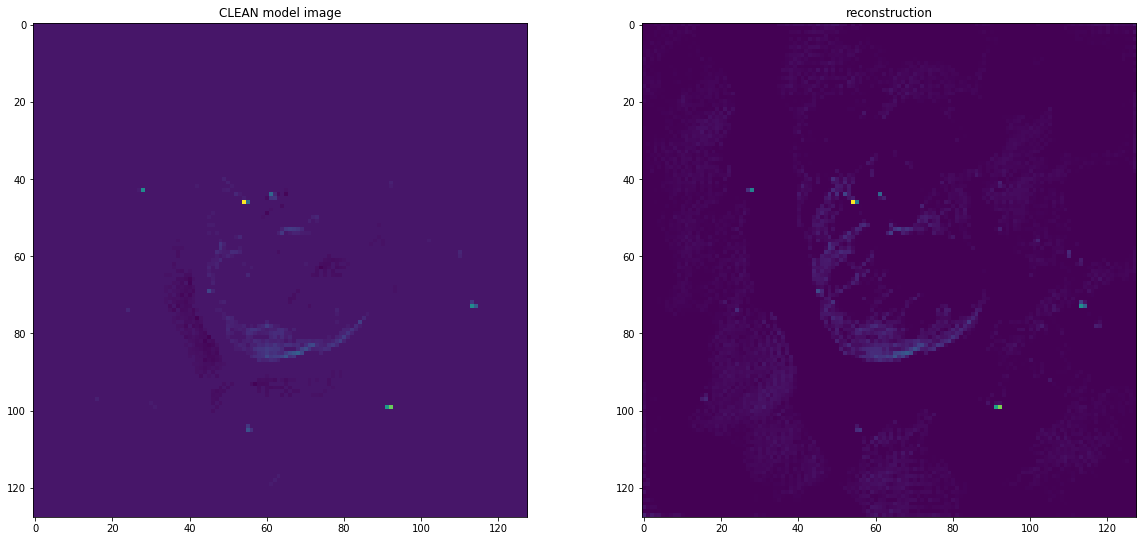

In [7]:
plot_comparison(model_map, 'CLEAN model image', results_dirty01, "reconstruction")

## Haar regularizer

$minimize \left \| D_b - x * PSF \right \|_2^2  + \lambda \left \| Hx \right \|_1 \; with\, x > 0$

In [14]:
dimensions = dirty_map.size
haar = np.zeros((dimensions,dimensions))
for j in range(0, dimensions):
    haar[0, j] = 1
    
p = 0
q = 1
p_val = 1
for k in range(1,dimensions):
    pixel = 2**(p/2)
    for j in range(0, dimensions):
        t = j/float(dimensions)
        if (q-1)/p_val <= t and t < (q-0.5)/p_val:
            haar[k, j] = pixel
        elif (q-0.5)/p_val <= t and t < q/p_val:
            haar[k, j] = -pixel
        else:
            haar[k, j] = 0
    q += 1
    if p_val == q-1:
        q = 1
        p += 1
        p_val = 1 << p
        
haar = 1.0/np.sqrt(dimensions) * haar

In [103]:
dimensions = dirty_map.size
haar2d = np.zeros((dimensions,dimensions))
norm = np.zeros(dimensions)
haar2d[0] = 1
norm[0] = dimensions

dim = np.zeros(dirty_map.shape)
def haar_insert(A,norm, x0,y0,x1,y1, k):
    xmid = int((x0+x1)/2)
    ymid = int((y0+y1)/2)

    dim[x0:xmid,y0:y1] = 1
    dim[xmid:x1,y0:y1] = -1
    haar2d[k] = dim.flatten()
    norm[k] = np.absolute(dim).sum()
    k += 1
    dim[x0:xmid,ymid:y1] = -1
    dim[xmid:x1,ymid:y1] = 1
    haar2d[k] = dim.flatten()
    norm[k] = np.absolute(dim).sum()
    k += 1
    dim[xmid:x1,y0:ymid] = 1
    dim[xmid:x1,ymid:y1] = -1
    haar2d[k] = dim.flatten()
    norm[k] = np.absolute(dim).sum()
    k += 1
    
    dim[x0:x1, y0:y1] = 0
    if x1-x0 > 2 and y1-y0 >2:
        k = haar_insert(A, norm, x0,y0,xmid,ymid, k)
        k = haar_insert(A, norm, xmid,y0,x1,ymid, k)
        k = haar_insert(A, norm, x0,ymid,xmid,y1, k)
        k = haar_insert(A, norm, xmid,ymid,x1,y1, k)
    return k

k = 1
haar_insert(haar2d, norm, 0, 0 ,dim.shape[0], dim.shape[1], k)
haar2d =np.transpose(1/np.sqrt(norm) * np.transpose(haar2d))
#np.dot(np.transpose(haar2d), haar2d)

In [104]:
model = Model("haar regularizer")
model.Params.method = 0 #GRB Primal Simplex 
psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
pixel_flat = []
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        v = model.addVar()
        row.append(v)
        pixel_flat.append(v)
    pixelArr.append(row)

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print("done psf modelling ", elapsed_time)

haar_var = model.addVars(dirty_map.size, lb=-GRB.INFINITY)     
haar_var_abs = model.addVars(dirty_map.size, lb=-GRB.INFINITY)
start_time = time.time()
for x in range(0, dirty_map.size):
    reg = LinExpr()
    reg.addTerms(haar2d[x], pixel_flat)
    model.addConstr(haar_var[x] == reg)
    model.addGenConstrAbs(haar_var_abs[x], haar_var[x])
elapsed_time = time.time() - start_time
print("done regularizer ", elapsed_time)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
psf filled to  62.9150390625 %
1.0
done psf modelling  17.58823800086975
done regularizer  20.357099056243896


In [107]:
lamb= 10
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    offset = x * dirty_map.shape[0]
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        objective += lamb * haar_var_abs[offset+y]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_haar = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_haar[x,y]= pixelArr[x][y].x

Optimize a model with 8192 rows, 16384 columns and 6062162 nonzeros
Model has 4096 quadratic objective terms
Model has 4096 general constraints
Variable types: 16384 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e+01, 1e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 3e+01]
Presolve removed 2 rows and 2 columns (presolve time = 6s) ...
Presolve removed 2 rows and 2 columns (presolve time = 10s) ...
Presolve added 8189 rows and 0 columns
Presolve removed 0 rows and 2 columns
Presolve time: 12.27s
Presolved: 16381 rows, 16382 columns, 6074445 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 16382 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00     14s
       0    9.2051311e+04   0.000000e+00   2.224917e+05     14s
     9

In [110]:
#np.savetxt("./output-csv/haar.csv",results_dirty01, delimiter=',')
haar_reg = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    offset = x * dirty_map.shape[0]
    for y in range(0, dirty_map.shape[0]):
        haar_reg[x,y]= haar_var_abs[offset+y].x


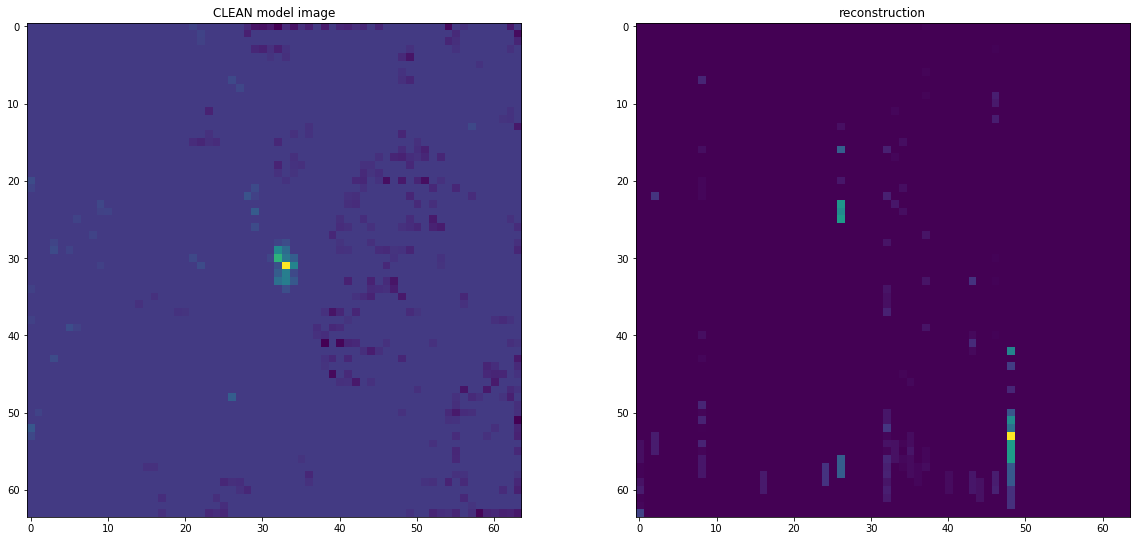

In [111]:
plot_comparison(model_map, 'CLEAN model image', haar_reg, "reconstruction")

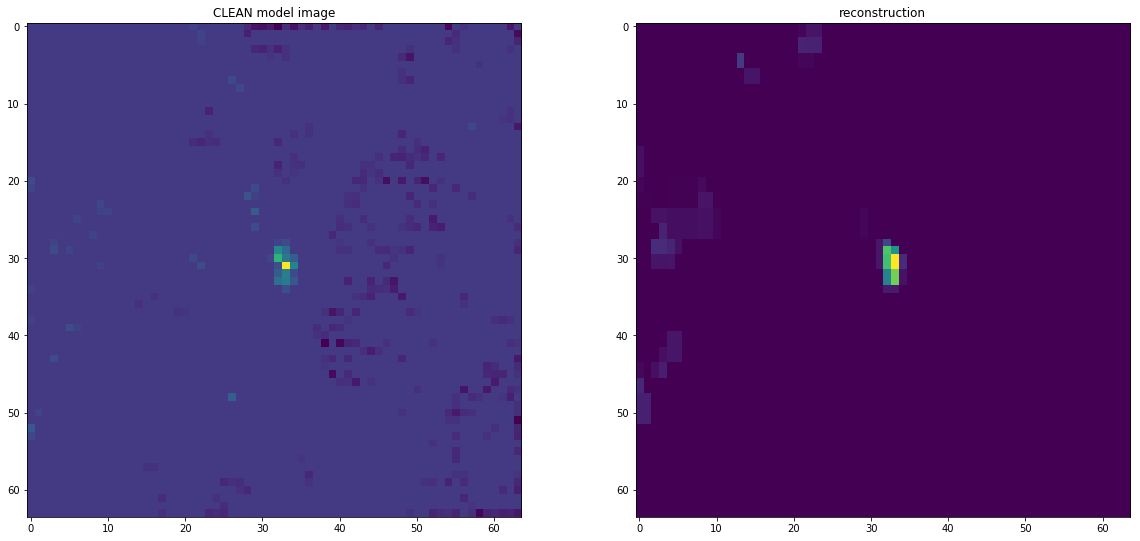

In [108]:
plot_comparison(model_map, 'CLEAN model image', results_haar, "reconstruction")

## Reconstruction with PSF with Total Variation regularizer

$minimize \left \| D_b - x * PSF \right \|_2^2 \; with\, x > 0$

In [20]:
model = Model("deconv with TV")
model.Params.method = 0 #GRB Primal Simplex 

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
pixel_flat = []
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        v = model.addVar()
        row.append(v)
        pixel_flat.append(v)
    pixelArr.append(row)
XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print("done psf modelling ", elapsed_time)
    
pixel_x_div = model.addVars(dirty_map.shape[0]-1, dirty_map.shape[1]-1, lb=-GRB.INFINITY)
pixel_x_div_abs = model.addVars(dirty_map.shape[0]-1, dirty_map.shape[1]-1, lb=-GRB.INFINITY)
pixel_y_div = model.addVars(dirty_map.shape[0]-1, dirty_map.shape[1]-1, lb=-GRB.INFINITY)
pixel_y_div_abs = model.addVars(dirty_map.shape[0]-1, dirty_map.shape[1]-1, lb=-GRB.INFINITY)
for x in range(0, dirty_map.shape[0]-1):
    for y in range(0, dirty_map.shape[1]-1):
        model.addConstr(pixel_x_div[x,y] == pixelArr[x+1][y] - pixelArr[x][y])
        model.addGenConstrAbs(pixel_x_div_abs[x,y], pixel_x_div[x,y])
        
        model.addConstr(pixel_y_div[x,y] == pixelArr[x][y+1] - pixelArr[x][y])
        model.addGenConstrAbs(pixel_y_div_abs[x,y],pixel_y_div[x,y])

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
psf filled to  62.9150390625 %
1.0
done psf modelling  11.719871997833252


In [21]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 0.5    
for x in range(0, dirty_map.shape[0]-1):
    for y in range(0, dirty_map.shape[1]-1):
        objective += lamb * (pixel_x_div_abs[x,y] + pixel_y_div_abs[x,y])

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_tv = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_tv[x,y]= pixelArr[x][y].x

Optimize a model with 12034 rows, 24068 columns and 6004056 nonzeros
Model has 4096 quadratic objective terms
Model has 7938 general constraints
Variable types: 24068 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [5e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 3e+01]
Presolve removed 7938 rows and 7938 columns (presolve time = 5s) ...
Presolve removed 7938 rows and 7938 columns (presolve time = 12s) ...
Presolve added 7938 rows and 0 columns
Presolve removed 0 rows and 7938 columns
Presolve time: 11.61s
Presolved: 19972 rows, 16130 columns, 6027870 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 16130 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00     13s
       0    9.2051311e+04   0.000000e+00   2.226667e+0

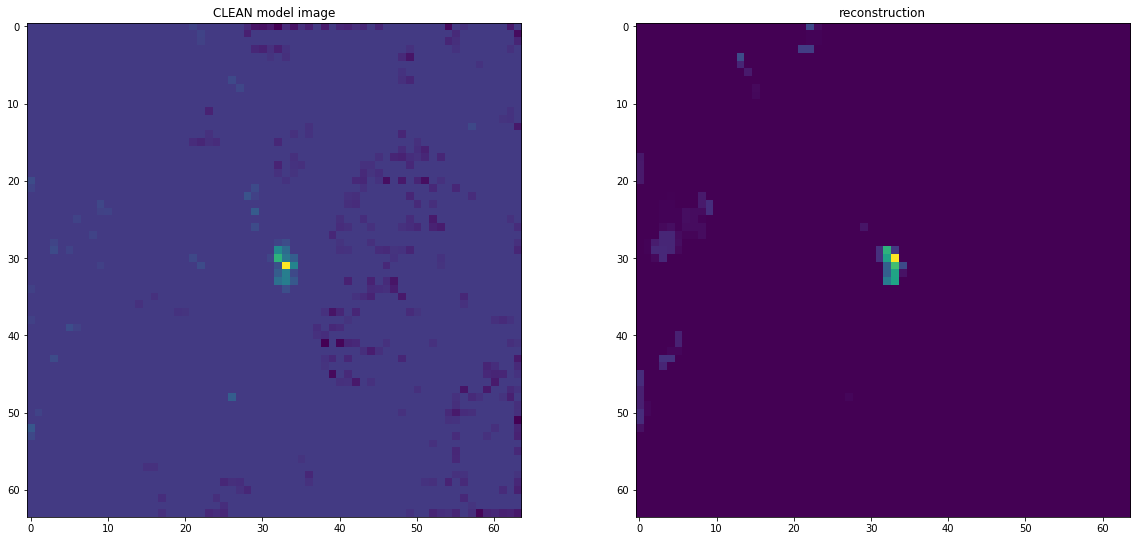

In [22]:
plot_comparison(model_map, 'CLEAN model image', results_tv, "reconstruction")

## Reconstruction with PSF with gaussian regularizer

$minimize \left \| D_b - x * PSF \right \|_2^2 \; with\, x > 0$

In [40]:
def createRegularizer(shape, kernel):
    template = np.zeros(shape)
    size= shape[0]*shape[1]
    H = np.zeros((size,size))

    i = 0
    offset = kernel.shape[0] // 2
    for x in range(0, shape[0]):
        maxX = min((x + offset),shape[0])
        minX = max((x - offset),0)

        kX = kernel
        if minX == 0:
            kX= kernel[kernel.shape[0]-maxX:kernel.shape[0]]
        elif maxX == shape[0]:
            kX = kernel[0:(shape[0] -x +offset)]

        for y in range(0, shape[1]):
            maxY = min((y + offset), shape[1])
            minY = max((y - offset ),0)
            kY = kX
            if minY == 0:
                kY = kY[0:kY.shape[0], kY.shape[1] -maxY:kY.shape[1]]
            if maxY == shape[1]:
                kY = kY[0:kY.shape[0], 0:(shape[1] - y +offset)]

            template[minX:maxX, minY:maxY]= kY
            H[i] = template.flatten()
            template[minX:maxX, minY:maxY]=0
            i += 1
    return(H)

In [50]:
length = dirty_map.shape[0]

fwhm = 3
minX = length //2 - fwhm*2
maxX = length //2 + fwhm*2
G1 = makeGaussian(length,fwhm=fwhm)[minX:maxX, minX:maxX]

fwhm = 6
minX = length //2 - fwhm*2
maxX = length //2 + fwhm*2
G2 = makeGaussian(length,fwhm=fwhm*2) [minX:maxX, minX:maxX]

H1 = createRegularizer(dirty_map.shape,G1)
H2 = createRegularizer(dirty_map.shape, G2)
H = np.append(H1, H2, axis=0)
plot_comparison(G1, 'Gaussian 1', G2, "Gaussian 2")

In [ ]:
psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

model = Model("starlet? regularizer")
model.Params.method = 0 #GRB Primal Simplex 
psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
pixel_flat = []
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        v = model.addVar()
        row.append(v)
        pixel_flat.append(v)
    pixelArr.append(row)
    
XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print("done psf modelling ", elapsed_time)

star_var = model.addVars(H.shape[0], lb=-GRB.INFINITY)
star_var_abs = model.addVars(H.shape[0], lb=-GRB.INFINITY)
start_time = time.time()
for x in range(0, H.shape[0]):
    reg = LinExpr()
    reg.addTerms(H[x], pixel_flat)
    model.addConstr(star_var[x] == reg)
    model.addGenConstrAbs(star_var_abs[x], star_var[x])
elapsed_time = time.time() - start_time
print("done regularizer ", elapsed_time)

In [ ]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 10    
for x in range(0, H.shape[0]):
    objective += lamb * star_var_abs[x]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_starlet = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_starlet[x,y]= pixelArr[x][y].x

In [ ]:
np.savetxt("./output-csv/starlet?.csv",results_dirty01, delimiter=',')

In [ ]:
plot_comparison(model_map, 'CLEAN model image', results_starlet, "reconstruction")

## Reconstruction with PSF with Starlet

$minimize \left \| D_b - x * PSF \right \|_2^2 \; with\, x > 0$

In [4]:
def calcSpline():
    b3spline = np.asarray([1/16, 1/4, 3/8, 1/4, 1/16])
    row = np.asmatrix([b3spline])
    return(np.dot(np.transpose(row),row))

#circular
def calcConvMatrix(size, kernel, J):
    output = np.zeros((size[0]*size[1], size[0]*size[1]))
    kernel = np.fliplr(np.flipud(kernel))
    
    disp = 2**J
    temp = np.zeros(size)
    for i in range(0, kernel.shape[0]):
        for j in range(0, kernel.shape[1]):
            x = (i * disp) % temp.shape[0]
            y = (j * disp) % temp.shape[1]
            temp[x,y] += kernel[i,j]
            
    mid = (kernel.shape[0]-1) * disp + 1
    temp = np.roll(temp, -(mid//2), axis= 0)
    temp = np.roll(temp, -(mid//2), axis=1)
    
    for x in range(0, size[0]):
        offset = x * size[0]
        for y in range(0, size[1]):
            output[offset+y] = temp.flatten()
            temp = np.roll(temp, 1, axis=1)
        temp = np.roll(temp, 1, axis=0)
    return(output)
    

In [5]:
def calcSpline():
    b3spline = np.asarray([1/16, 1/4, 3/8, 1/4, 1/16])
    row = np.asmatrix([b3spline])
    return(np.dot(np.transpose(row),row))

#repeat
def calcConvMatrix(size, kernel, J):
    output = np.zeros((size[0]*size[1], size[0]*size[1]))
    kernel = np.fliplr(np.flipud(kernel))
    
    disp = 2**J
    mid = kernel.shape[0]//2
    for x in range(0, size[0]):
        offset = x * size[0]
        for y in range(0, size[1]):
            temp = np.reshape(output[offset+y], size)
            for i in range(0, kernel.shape[0]):
                for j in range(0, kernel.shape[1]):
                    xi = ((i - mid) * disp + x)
                    yi = ((j - mid) * disp + y)
                    #print(xi, yi)
                    mx = xi // size[0] % 2
                    xi = xi % size[0]
                    if mx == 1:
                        xi = size[0] -1 - xi

                    my = yi // size[1] % 2
                    yi = yi % size[1]
                    if my == 1:
                        yi = size[1] -1 - yi
                    #print(mx, my, xi, yi)
                    temp[xi, yi] += kernel[i,j]
    return(output)

In [38]:
#zero padding
def calcConvMatrix(size, kernel, J):
    output = np.zeros((size[0]*size[1], size[0]*size[1]))
    kernel = np.fliplr(np.flipud(kernel))
    
    disp = 2**J
    mid = kernel.shape[0]//2
    for x in range(0, size[0]):
        offset = x * size[0]
        for y in range(0, size[1]):
            temp = np.reshape(output[offset+y], size)
            for i in range(0, kernel.shape[0]):
                for j in range(0, kernel.shape[1]):
                    xi = ((i - mid) * disp + x)
                    yi = ((j - mid) * disp + y)
                    if xi >= 0 and yi >= 0 and xi < size[0] and yi < size[1]:
                        temp[xi, yi] += kernel[i,j]
    return(output)

In [61]:
kernel = calcSpline()
mat = calcConvMatrix((8,8), kernel, 2)

In [62]:
np.reshape(mat[0],(8,8))

array([[0.140625, 0.      , 0.      , 0.      , 0.09375 , 0.      ,
        0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      ],
       [0.09375 , 0.      , 0.      , 0.      , 0.0625  , 0.      ,
        0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      ]])

In [91]:
def calcConvMatrix(size, kernel, J):
    output= np.zeros((size[0]*size[1], size[0]*size[1]))
    for i in range(0,size[0]*size[1]):
        output[i,i] = 1
    return output

In [92]:
model = Model("starlet regularizer")
model.Params.method = 0 #GRB Primal Simplex 

psf = psf_map.copy()
psf[np.absolute(psf) < 0.02] = 0 #clip negative psf values
print("psf filled to ", np.count_nonzero(psf)/psf.size*100, "%")
lo = int(math.ceil(psf.shape[0]/4))
hi = psf.shape[0]-int(math.floor(psf.shape[0]/4))
#psf= psf[lo:hi,lo:hi] #reduce psf size
psf = np.fliplr(np.flipud(psf))

psf_sum = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
pixel_flat = []
pixelArr = []
for x in range(0, dirty_map.shape[0]):
    row =[]
    for y in range(0, dirty_map.shape[1]):
        v = model.addVar()
        row.append(v)
        pixel_flat.append(v)
    pixelArr.append(row)
    
XCenter = int(math.floor((psf.shape[0] -1)/2))
YCenter = int(math.floor((psf.shape[1] -1)/2))
print(psf[XCenter, YCenter])
start_time = time.time()
for x in range(0, dirty_map.shape[0]):
    psfX0 = -min(x - XCenter, 0)
    psfX1= min(psf.shape[0] -1, XCenter + (dirty_map.shape[0] -1 - x))
    X0 = max(x - XCenter, 0)
    for y in range(0, dirty_map.shape[1]):
        Y0 = max(y - YCenter, 0)
        Y1 = min(y + (psf.shape[1] - YCenter -1), dirty_map.shape[1] -1)
        psfY0 = -min(y - YCenter, 0)
        psfY1 = min(psf.shape[1] -1, YCenter + (dirty_map.shape[1] -1 - y))
        
        #print(x, psfX0, psfX1)
        convolution = LinExpr()
        for xp in range(0, psfX1 - psfX0 + 1):
            psf_cut= psf[xp+ psfX0, psfY0:psfY1 + 1]
            pixel_cut = pixelArr[X0+xp][Y0:Y1+1]
            convolution.addTerms(psf_cut, pixel_cut)
        model.addConstr(psf_sum[x,y] == dirty_map[x,y] - convolution, "conv")
elapsed_time = time.time() - start_time
print("done psf modelling ", elapsed_time)

start_time = time.time()
starlet_levels=2
#starlet_levels = int(math.log(dirty_map.shape[0], 2))
star_c = []
star_w = []
star_w_abs = []
b3spline = calcSpline()
M_previous = 0
for J in range(0, starlet_levels):
    print("modelling starlet level "+ str(J+1) +" of "+ str(starlet_levels))
    
    star_cJ = []
    star_wJ = []
    star_wJ_abs = []
    for x in range(0, dirty_map.size):
        star_cJ.append(model.addVar(lb=-GRB.INFINITY))
        star_wJ.append(model.addVar(lb=-GRB.INFINITY))
        star_wJ_abs.append(model.addVar())
    star_c.append(star_cJ)
    star_w.append(star_wJ)
    star_w_abs.append(star_wJ_abs)
    
    star_cminus = 0
    if J == 0:
        star_cminus = pixel_flat
        MJ = calcConvMatrix(dirty_map.shape, b3spline, J)
    else:
        star_cminus = star_c[J-1]
        MJ = np.dot(M_previous,calcConvMatrix(dirty_map.shape, b3spline, J))
    for x in range(0, dirty_map.size):
        reg = LinExpr()
        reg.addTerms(MJ[x], pixel_flat)
        model.addConstr(star_cJ[x] == reg)
        model.addConstr(star_wJ[x] ==  star_cminus[x] - star_cJ[x])
        model.addGenConstrAbs(star_wJ_abs[x], star_wJ[x])
    M_previous = MJ

print("modeling cJ")
star_c_abs= []
for x in range(0, dirty_map.size):
    star_c_abs.append(model.addVar())
    model.addGenConstrAbs(star_c_abs[x], star_c[J-1][x])
    
elapsed_time = time.time() - start_time
print("done starlet modelling ", elapsed_time)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
psf filled to  12.20703125 %
1.0
done psf modelling  11.561639785766602
modelling starlet level 1 of 2
modelling starlet level 2 of 2
modeling cJ
done starlet modelling  32.070788621902466


In [93]:
objective = QuadExpr()
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[1]):
        # L2[Dirty - X * PSF]
        objective += psf_sum[x,y] * psf_sum[x,y]
        
lamb= 0.01 / starlet_levels
for J in range(0, starlet_levels):
    star_wJ_abs = star_w_abs[J]
    for x in range(0, dirty_map.size):
        objective += lamb * star_wJ_abs[x]
                                        
for x in range(0, dirty_map.size):
        objective += lamb * star_c_abs[x]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

results_starlet = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    for y in range(0, dirty_map.shape[0]):
        results_starlet[x,y]= pixelArr[x][y].x

Optimize a model with 20480 rows, 36864 columns and 2318950 nonzeros
Model has 4096 quadratic objective terms
Model has 12288 general constraints
Variable types: 36864 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [5e-03, 5e-03]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-08, 8e-03]
Presolve removed 12288 rows and 12288 columns (presolve time = 5s) ...
Presolve added 8192 rows and 0 columns
Presolve removed 0 rows and 12288 columns
Presolve time: 7.11s
Presolved: 28672 rows, 24576 columns, 2317046 nonzeros
Presolved model has 4096 quadratic objective terms
Variable types: 24576 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      8s
       0    4.2339900e-03   0.000000e+00   1.776211e+01      8s
    2618    3.2425853e-03   0.000000e+00   2.281892e+01  

   69923    4.2339900e-03   0.000000e+00   1.687486e+04    570s
   70427    4.2339900e-03   0.000000e+00   1.557185e+04    576s
   70931    4.2339900e-03   0.000000e+00   7.088905e+04    581s
   71267    4.2339900e-03   0.000000e+00   1.323342e+03    585s
   71771    4.2339900e-03   0.000000e+00   8.043245e+03    592s
   72107    4.2339900e-03   0.000000e+00   2.033033e+02    596s
   72443    4.2339900e-03   0.000000e+00   2.242511e+03    600s
   72947    4.2339900e-03   0.000000e+00   3.390763e+04    605s
   73451    4.2339900e-03   0.000000e+00   6.518703e+03    611s
   73955    4.2339900e-03   0.000000e+00   4.604559e+04    616s
   74459    4.2339900e-03   0.000000e+00   8.674834e+02    621s
   74963    4.2339900e-03   0.000000e+00   8.939166e+03    626s
   75467    4.2339900e-03   0.000000e+00   6.284902e+02    631s
   75971    4.2339900e-03   0.000000e+00   2.951198e+03    636s
   76475    4.2339900e-03   0.000000e+00   4.106914e+03    640s
   77147    4.2339900e-03   0.000000e+00

  141659    4.2339900e-03   0.000000e+00   1.807296e+04   1216s
  142163    4.2339900e-03   0.000000e+00   1.836816e+03   1221s
  142667    4.2339900e-03   0.000000e+00   2.399740e+03   1226s
  143171    4.2339900e-03   0.000000e+00   1.613341e+03   1230s
  143843    4.2339900e-03   0.000000e+00   6.979459e+02   1236s
  144347    4.2339900e-03   0.000000e+00   8.475749e+03   1240s
  145019    4.2339900e-03   0.000000e+00   2.003252e+04   1246s
  145691    4.2339900e-03   0.000000e+00   7.015902e+04   1251s
  146195    4.2339900e-03   0.000000e+00   8.384058e+02   1256s
  146867    4.2339900e-03   0.000000e+00   1.414861e+03   1261s
  147371    4.2339900e-03   0.000000e+00   1.435648e+04   1265s
  148043    4.2339900e-03   0.000000e+00   7.881036e+03   1271s
  148715    4.2339900e-03   0.000000e+00   8.497537e+03   1276s
  149219    4.2339900e-03   0.000000e+00   3.516561e+03   1281s
  149723    4.2339900e-03   0.000000e+00   5.821606e+05   1285s
  150395    4.2339900e-03   0.000000e+00

  212555    4.2339900e-03   0.000000e+00   3.408513e+03   1860s
  213227    4.2339900e-03   0.000000e+00   5.082281e+02   1866s
  213731    4.2339900e-03   0.000000e+00   1.650832e+03   1871s
  214235    4.2339900e-03   0.000000e+00   2.485525e+03   1876s
  214739    4.2339900e-03   0.000000e+00   4.695593e+03   1881s
  215243    4.2339900e-03   0.000000e+00   5.182626e+04   1886s
  215747    4.2339900e-03   0.000000e+00   2.314886e+03   1890s
  216419    4.2339900e-03   0.000000e+00   5.584212e+04   1896s
  216923    4.2339900e-03   0.000000e+00   1.469100e+03   1900s
  217595    4.2339900e-03   0.000000e+00   5.605864e+02   1906s
  218267    4.2339900e-03   0.000000e+00   2.665606e+03   1911s
  218939    4.2339900e-03   0.000000e+00   7.659698e+03   1916s
  219443    4.2339900e-03   0.000000e+00   4.596253e+03   1920s
  220115    4.2339900e-03   0.000000e+00   1.921854e+03   1926s
  220619    4.2339900e-03   0.000000e+00   2.421875e+03   1931s
  221123    4.2339900e-03   0.000000e+00

  287147    4.2339900e-03   0.000000e+00   2.466939e+03   2506s
  287651    4.2339900e-03   0.000000e+00   1.855523e+03   2510s
  288323    4.2339900e-03   0.000000e+00   3.477195e+03   2516s
  288827    4.2339900e-03   0.000000e+00   1.785971e+03   2521s
  289331    4.2339900e-03   0.000000e+00   4.319765e+03   2526s
  289835    4.2339900e-03   0.000000e+00   3.757461e+03   2530s
  290339    4.2339900e-03   0.000000e+00   6.731410e+02   2535s
  291011    4.2339900e-03   0.000000e+00   2.462186e+04   2541s
  291515    4.2339900e-03   0.000000e+00   9.687049e+03   2546s
  292019    4.2339900e-03   0.000000e+00   4.411046e+03   2551s
  292523    4.2339900e-03   0.000000e+00   1.334768e+05   2555s
  293195    4.2339900e-03   0.000000e+00   1.439965e+05   2561s
  293699    4.2339900e-03   0.000000e+00   5.101465e+03   2565s
  294371    4.2339900e-03   0.000000e+00   7.161892e+03   2571s
  294875    4.2339900e-03   0.000000e+00   1.340612e+04   2576s
  295547    4.2339900e-03   0.000000e+00

  361739    4.2321222e-03   0.000000e+00   4.251545e+03   3150s
  362411    4.2319355e-03   0.000000e+00   1.684592e+03   3156s
  362915    4.2309454e-03   0.000000e+00   1.027691e+04   3161s
  363419    4.2337124e-03   0.000000e+00   2.508879e+03   3166s
  363923    4.2311278e-03   0.000000e+00   5.617766e+05   3170s
  364595    4.2228430e-03   0.000000e+00   7.247832e+03   3177s
  364931    4.2178864e-03   0.000000e+00   2.296807e+03   3180s
  365435    4.2159357e-03   0.000000e+00   1.542276e+03   3185s
  366107    4.2089316e-03   0.000000e+00   1.846550e+03   3191s
  366611    4.2257316e-03   0.000000e+00   2.105234e+03   3196s
  367115    4.2174443e-03   0.000000e+00   3.733854e+03   3201s
  367619    4.2296734e-03   0.000000e+00   4.183683e+03   3206s
  368123    4.2300416e-03   0.000000e+00   1.784521e+03   3211s
  368627    4.2616655e-03   0.000000e+00   6.395730e+03   3216s
  369131    4.2766005e-03   0.000000e+00   2.921169e+04   3221s
  369635    4.2974314e-03   0.000000e+00

  401549    3.9158584e-03   0.000000e+00   3.074277e+06   3808s
  401700    3.8599595e-03   0.000000e+00   4.941632e+05   3813s
  401851    3.8395620e-03   0.000000e+00   1.783724e+04   3818s
  402002    3.8396668e-03   0.000000e+00   2.424294e+04   3823s
  402153    3.8379104e-03   0.000000e+00   5.383828e+04   3828s
  402304    3.8208210e-03   0.000000e+00   1.417304e+06   3833s
  402455    3.8116438e-03   0.000000e+00   1.744046e+03   3839s
  402606    3.7935793e-03   0.000000e+00   1.543126e+05   3843s
  402757    3.7932116e-03   0.000000e+00   6.282192e+04   3848s
  402908    3.7928246e-03   0.000000e+00   2.724129e+04   3852s
  403059    3.8073874e-03   0.000000e+00   1.092086e+05   3857s
  403159    3.7813647e-03   0.000000e+00   6.176173e+04   3861s
  403295    3.7603859e-03   0.000000e+00   1.946769e+04   3867s
  403431    3.8199860e-03   0.000000e+00   2.133550e+05   3871s
  403567    3.8054253e-03   0.000000e+00   6.309818e+06   3877s
  403703    3.7889237e-03   0.000000e+00

  416731    2.9769861e-03   0.000000e+00   1.139484e+06   4937s
  416833    2.9731266e-03   0.000000e+00   1.076720e+04   4947s
  416935    2.9402075e-03   0.000000e+00   7.603744e+03   4958s
  417037    2.9237901e-03   0.000000e+00   3.059901e+04   4969s
  417139    2.9232249e-03   0.000000e+00   1.570591e+06   4979s
  417241    2.9067762e-03   0.000000e+00   3.245958e+03   4990s
  417343    2.8971910e-03   0.000000e+00   5.717170e+03   5000s
  417445    2.8993301e-03   0.000000e+00   1.635160e+04   5011s
  417547    2.9079497e-03   0.000000e+00   7.541089e+04   5024s
  417649    2.8980021e-03   0.000000e+00   1.768474e+05   5034s
  417751    2.8945205e-03   0.000000e+00   1.523941e+05   5045s
  417853    2.9146534e-03   0.000000e+00   2.875081e+05   5056s
  417955    2.8837137e-03   0.000000e+00   1.641491e+05   5065s
  418057    2.9839197e-03   0.000000e+00   8.642989e+03   5077s
  418159    2.8155490e-03   0.000000e+00   1.372450e+05   5087s
  418261    2.8383060e-03   0.000000e+00

  435499    4.2331138e-03   0.000000e+00   4.404736e+02   5750s
  435703    4.2348530e-03   0.000000e+00   3.841634e+02   5756s
  435907    4.2429072e-03   0.000000e+00   2.591284e+02   5761s
  436111    4.2350508e-03   0.000000e+00   8.008915e+02   5766s
  436315    4.2369146e-03   0.000000e+00   4.780632e+02   5771s
  436519    4.2374602e-03   0.000000e+00   2.972440e+02   5776s
  436723    4.2442272e-03   0.000000e+00   9.360087e+02   5781s
  436927    4.2420840e-03   0.000000e+00   3.075773e+02   5787s
  437131    4.2338797e-03   0.000000e+00   1.460953e+03   5793s
  437233    4.2333580e-03   0.000000e+00   1.134559e+03   5795s
  437437    4.2309247e-03   0.000000e+00   5.553431e+02   5801s
  437641    4.2278280e-03   0.000000e+00   4.786401e+03   5807s
  437845    4.2238025e-03   0.000000e+00   9.172225e+02   5812s
  438049    4.2355563e-03   0.000000e+00   3.656200e+03   5818s
  438151    4.2386612e-03   0.000000e+00   8.926373e+02   5820s
  438355    4.2357469e-03   0.000000e+00

  457633    4.6514137e-03   0.000000e+00   9.192235e+02   6399s
  457735    4.6460626e-03   0.000000e+00   2.108239e+03   6402s
  457837    4.6432288e-03   0.000000e+00   7.519063e+03   6406s
  458041    4.6510868e-03   0.000000e+00   9.263181e+02   6413s
  458143    4.6528554e-03   0.000000e+00   4.040696e+03   6417s
  458245    4.6454663e-03   0.000000e+00   2.212978e+03   6420s
  458449    4.6468512e-03   0.000000e+00   4.211884e+04   6428s
  458551    4.6449015e-03   0.000000e+00   7.420258e+02   6431s
  458755    4.6533011e-03   0.000000e+00   2.785013e+04   6438s
  458857    4.6456648e-03   0.000000e+00   2.159338e+03   6441s
  459061    4.6502947e-03   0.000000e+00   6.876564e+02   6448s
  459163    4.6497546e-03   0.000000e+00   1.843405e+03   6452s
  459265    4.6575792e-03   0.000000e+00   2.854593e+03   6455s
  459469    4.6651637e-03   0.000000e+00   2.727489e+03   6463s
  459571    4.6728821e-03   0.000000e+00   8.287905e+03   6466s
  459673    4.6748154e-03   0.000000e+00

  474870    4.8265435e-03   0.000000e+00   1.963816e+03   7042s
  474972    4.8298757e-03   0.000000e+00   2.630200e+03   7046s
  475074    4.8246442e-03   0.000000e+00   1.670372e+03   7050s
  475278    4.8226217e-03   0.000000e+00   1.972200e+03   7059s
  475380    4.8279135e-03   0.000000e+00   4.246658e+03   7063s
  475482    4.8374071e-03   0.000000e+00   1.326515e+03   7067s
  475584    4.8327647e-03   0.000000e+00   2.408745e+04   7071s
  475686    4.8279704e-03   0.000000e+00   8.456014e+03   7076s
  475890    4.8293522e-03   0.000000e+00   6.698692e+03   7083s
  475992    4.8390159e-03   0.000000e+00   1.812436e+05   7088s
  476094    4.8279357e-03   0.000000e+00   9.006041e+03   7091s
  476196    4.8357107e-03   0.000000e+00   5.506808e+04   7096s
  476400    4.8482688e-03   0.000000e+00   4.485381e+03   7104s
  476502    4.8243823e-03   0.000000e+00   6.833083e+03   7108s
  476604    4.8609037e-03   0.000000e+00   1.711976e+03   7112s
  476706    4.8910753e-03   0.000000e+00

  489864    5.2117220e-03   0.000000e+00   7.989174e+03   7687s
  489966    5.2142290e-03   0.000000e+00   1.706731e+04   7692s
  490068    5.2273623e-03   0.000000e+00   5.806663e+03   7696s
  490170    5.2254008e-03   0.000000e+00   1.246381e+03   7700s
  490272    5.2184546e-03   0.000000e+00   1.143773e+04   7705s
  490374    5.2192231e-03   0.000000e+00   1.681932e+03   7710s
  490476    5.2216863e-03   0.000000e+00   4.495260e+03   7715s
  490578    5.2182860e-03   0.000000e+00   7.228368e+03   7720s
  490782    5.2241106e-03   0.000000e+00   8.777788e+03   7729s
  490884    5.2332297e-03   0.000000e+00   2.904599e+03   7734s
  490986    5.2578546e-03   0.000000e+00   4.427318e+03   7739s
  491088    5.2624241e-03   0.000000e+00   9.874108e+03   7744s
  491190    5.2791657e-03   0.000000e+00   5.920878e+03   7748s
  491292    5.2654737e-03   0.000000e+00   7.310761e+03   7753s
  491394    5.2578318e-03   0.000000e+00   4.893775e+03   7759s
  491496    5.2610822e-03   0.000000e+00

  505572    4.2389544e-03   0.000000e+00   1.328512e+03   8336s
  505776    4.2495511e-03   0.000000e+00   2.683242e+02   8342s
  505980    4.2540918e-03   0.000000e+00   1.989769e+02   8348s
  506082    4.2596414e-03   0.000000e+00   2.712344e+02   8350s
  506286    4.2691486e-03   0.000000e+00   6.228427e+02   8356s
  506490    4.2590284e-03   0.000000e+00   1.509080e+03   8361s
  506694    4.2566022e-03   0.000000e+00   5.891160e+02   8367s
  506898    4.2593312e-03   0.000000e+00   4.357085e+02   8373s
  507000    4.2674761e-03   0.000000e+00   1.059022e+03   8375s
  507204    4.2690833e-03   0.000000e+00   5.740638e+02   8381s
  507408    4.2677090e-03   0.000000e+00   5.868292e+02   8387s
  507510    4.2679937e-03   0.000000e+00   6.554789e+02   8391s
  507714    4.2718860e-03   0.000000e+00   2.988450e+03   8397s
  507918    4.2755824e-03   0.000000e+00   6.146422e+02   8402s
  508020    4.2647349e-03   0.000000e+00   5.683059e+02   8406s
  508224    4.2662840e-03   0.000000e+00

  526176    4.5606164e-03   0.000000e+00   1.724443e+03   8981s
  526278    4.5574429e-03   0.000000e+00   3.807299e+03   8986s
  526482    4.5826028e-03   0.000000e+00   1.084135e+05   8993s
  526584    4.5795927e-03   0.000000e+00   9.432622e+04   8997s
  526686    4.5603215e-03   0.000000e+00   1.660204e+03   9001s
  526890    4.5600279e-03   0.000000e+00   4.483425e+03   9008s
  526992    4.5436882e-03   0.000000e+00   5.292297e+03   9012s
  527094    4.5463066e-03   0.000000e+00   5.898313e+03   9016s
  527196    4.5479465e-03   0.000000e+00   2.024169e+04   9020s
  527400    4.5574199e-03   0.000000e+00   3.244907e+03   9028s
  527502    4.5644561e-03   0.000000e+00   4.488100e+04   9032s
  527604    4.5648180e-03   0.000000e+00   3.036941e+03   9036s
  527808    4.5691246e-03   0.000000e+00   4.067944e+03   9043s
  527910    4.5563477e-03   0.000000e+00   2.982199e+03   9047s
  528012    4.5662276e-03   0.000000e+00   4.291651e+03   9051s
  528216    4.5499431e-03   0.000000e+00

  542904    4.8196325e-03   0.000000e+00   1.609164e+04   9627s
  543006    4.8075632e-03   0.000000e+00   2.407427e+03   9631s
  543108    4.8034275e-03   0.000000e+00   2.519425e+03   9635s
  543312    4.7806789e-03   0.000000e+00   7.734736e+03   9644s
  543414    4.7944751e-03   0.000000e+00   8.097695e+03   9648s
  543516    4.7821161e-03   0.000000e+00   2.578261e+04   9651s
  543618    4.7829135e-03   0.000000e+00   9.455869e+02   9655s
  543822    4.7755405e-03   0.000000e+00   3.509821e+03   9664s
  543924    4.7856940e-03   0.000000e+00   9.360426e+03   9668s
  544026    4.7949805e-03   0.000000e+00   5.616162e+03   9673s
  544128    4.7880651e-03   0.000000e+00   1.436790e+03   9677s
  544230    4.7903379e-03   0.000000e+00   4.409659e+03   9681s
  544332    4.7838969e-03   0.000000e+00   4.724858e+03   9685s
  544536    4.8100339e-03   0.000000e+00   1.933884e+03   9694s
  544638    4.7994857e-03   0.000000e+00   2.205967e+04   9697s
  544740    4.7847151e-03   0.000000e+00

  557898    4.7294971e-03   0.000000e+00   2.326821e+04  10277s
  558000    4.7244418e-03   0.000000e+00   3.732957e+03  10281s
  558102    4.7305118e-03   0.000000e+00   9.588510e+03  10286s
  558204    4.7292031e-03   0.000000e+00   7.730625e+03  10291s
  558306    4.2339900e-03   0.000000e+00   8.792052e+02  10298s
  558408    4.2339900e-03   0.000000e+00   1.327895e+03  10302s
  558510    4.2339900e-03   0.000000e+00   7.493800e+02  10306s
  558612    4.2339900e-03   0.000000e+00   7.617398e+02  10311s
  558816    4.2339900e-03   0.000000e+00   1.007771e+03  10319s
  558918    4.2339900e-03   0.000000e+00   9.133983e+02  10324s
  559020    4.2339900e-03   0.000000e+00   1.263166e+03  10328s
  559122    4.2339900e-03   0.000000e+00   1.608797e+03  10332s
  559224    4.2339900e-03   0.000000e+00   6.115371e+02  10336s
  559428    4.2339900e-03   0.000000e+00   6.966533e+02  10343s
  559530    4.2339900e-03   0.000000e+00   4.630853e+02  10347s
  559632    4.2339900e-03   0.000000e+00

  579114    4.3444813e-03   0.000000e+00   4.988728e+02  10915s
  579318    4.3469539e-03   0.000000e+00   4.045694e+02  10920s
  579522    4.3473473e-03   0.000000e+00   1.685106e+03  10927s
  579726    4.3350653e-03   0.000000e+00   2.260064e+03  10932s
  579828    4.3374989e-03   0.000000e+00   3.152233e+03  10935s
  580032    4.3436893e-03   0.000000e+00   1.989586e+03  10941s
  580236    4.3315211e-03   0.000000e+00   4.053965e+03  10947s
  580440    4.3279541e-03   0.000000e+00   6.877579e+02  10953s
  580542    4.3221257e-03   0.000000e+00   1.335064e+03  10956s
  580746    4.3266288e-03   0.000000e+00   2.758263e+03  10962s
  580848    4.3196595e-03   0.000000e+00   1.260300e+03  10965s
  581052    4.3333662e-03   0.000000e+00   2.918974e+03  10971s
  581256    4.3427052e-03   0.000000e+00   3.418226e+03  10977s
  581460    4.3499585e-03   0.000000e+00   2.516134e+03  10983s
  581562    4.3582578e-03   0.000000e+00   1.239086e+03  10986s
  581766    4.3504424e-03   0.000000e+00

  599412    4.8226782e-03   0.000000e+00   3.503928e+03  11562s
  599514    4.8280507e-03   0.000000e+00   3.031305e+03  11566s
  599718    4.8282796e-03   0.000000e+00   1.469230e+04  11573s
  599820    4.8228953e-03   0.000000e+00   1.487273e+03  11576s
  600024    4.8172922e-03   0.000000e+00   4.593817e+03  11584s
  600126    4.8128502e-03   0.000000e+00   1.088991e+04  11587s
  600228    4.8112563e-03   0.000000e+00   2.947831e+03  11591s
  600432    4.8195803e-03   0.000000e+00   5.225034e+04  11598s
  600534    4.8093235e-03   0.000000e+00   5.021289e+03  11602s
  600636    4.8071924e-03   0.000000e+00   3.222131e+03  11605s
  600840    4.8101469e-03   0.000000e+00   4.560535e+03  11612s
  600942    4.8062987e-03   0.000000e+00   1.187335e+04  11616s
  601146    4.8464595e-03   0.000000e+00   1.678887e+03  11623s
  601248    4.8346540e-03   0.000000e+00   3.450433e+03  11627s
  601350    4.8425313e-03   0.000000e+00   8.766017e+03  11630s
  601554    4.8281487e-03   0.000000e+00

  615120    4.6223756e-03   0.000000e+00   2.057433e+03  12205s
  615222    4.6129424e-03   0.000000e+00   3.528258e+03  12210s
  615324    4.5923373e-03   0.000000e+00   2.024806e+05  12216s
  615426    4.6208009e-03   0.000000e+00   1.629999e+04  12221s
  615528    4.6109076e-03   0.000000e+00   1.113681e+04  12226s
  615630    4.6090340e-03   0.000000e+00   9.005681e+03  12231s
  615732    4.6313972e-03   0.000000e+00   5.620556e+03  12235s
  615834    4.6390867e-03   0.000000e+00   1.228539e+04  12241s
  615936    4.6216447e-03   0.000000e+00   4.726272e+03  12245s
  616038    4.6193280e-03   0.000000e+00   3.213117e+03  12251s
  616140    4.6297540e-03   0.000000e+00   8.168154e+03  12256s
  616242    4.6286934e-03   0.000000e+00   1.391786e+04  12261s
  616344    4.6330879e-03   0.000000e+00   1.271025e+05  12265s
  616446    4.6263148e-03   0.000000e+00   1.747470e+05  12270s
  616548    4.6472650e-03   0.000000e+00   6.590669e+03  12275s
  616752    4.5973565e-03   0.000000e+00

  628380    4.8178504e-03   0.000000e+00   2.948446e+04  12957s
  628482    4.6804825e-03   0.000000e+00   3.688420e+04  12963s
  628584    4.6783219e-03   0.000000e+00   8.619673e+04  12970s
  628686    4.6679171e-03   0.000000e+00   2.282668e+07  12977s
  628788    4.7995976e-03   0.000000e+00   8.512600e+04  12983s
  628890    4.9699788e-03   0.000000e+00   7.197252e+04  12989s
  628992    4.9307030e-03   0.000000e+00   2.939405e+04  12995s
  629094    4.8876311e-03   0.000000e+00   1.324327e+06  13002s
  629196    4.8833753e-03   0.000000e+00   1.606608e+04  13008s
  629298    5.1079249e-03   0.000000e+00   6.952532e+05  13015s
  629400    5.0775360e-03   0.000000e+00   4.108687e+05  13022s
  629502    5.0580796e-03   0.000000e+00   1.665804e+05  13030s
  629604    5.0313496e-03   0.000000e+00   9.959377e+03  13037s
  629706    5.0083778e-03   0.000000e+00   2.702848e+04  13043s
  629808    4.9229936e-03   0.000000e+00   1.955115e+04  13050s
  629910    4.9529416e-03   0.000000e+00

  643012    4.1926249e-03   0.000000e+00   3.266518e+03  13813s
  643114    4.2018627e-03   0.000000e+00   1.366129e+03  13817s
  643216    4.2037252e-03   0.000000e+00   1.430258e+03  13820s
  643420    4.2135670e-03   0.000000e+00   7.873930e+02  13827s
  643522    4.2142007e-03   0.000000e+00   4.979208e+02  13831s
  643726    4.2355495e-03   0.000000e+00   8.352220e+02  13837s
  643930    4.2422244e-03   0.000000e+00   3.930084e+02  13843s
  644032    4.2352075e-03   0.000000e+00   1.438614e+03  13845s
  644236    4.2498942e-03   0.000000e+00   1.332115e+03  13851s
  644440    4.2523910e-03   0.000000e+00   8.948533e+02  13856s
  644644    4.2512700e-03   0.000000e+00   1.344758e+03  13862s
  644848    4.2604322e-03   0.000000e+00   1.339307e+03  13868s
  644950    4.2562303e-03   0.000000e+00   6.073426e+02  13870s
  645154    4.2600607e-03   0.000000e+00   7.329475e+02  13877s
  645358    4.2689527e-03   0.000000e+00   3.103848e+03  13883s
  645460    4.2804725e-03   0.000000e+00

  663310    4.4546001e-03   0.000000e+00   3.917815e+03  14458s
  663412    4.4700086e-03   0.000000e+00   5.387697e+03  14461s
  663514    4.4722605e-03   0.000000e+00   5.329567e+03  14465s
  663718    4.4715407e-03   0.000000e+00   1.621087e+05  14473s
  663820    4.4668181e-03   0.000000e+00   2.908483e+03  14477s
  663922    4.4630698e-03   0.000000e+00   7.504026e+03  14481s
  664126    4.5619251e-03   0.000000e+00   1.210496e+04  14488s
  664228    4.5496865e-03   0.000000e+00   7.197544e+04  14491s
  664330    4.5576275e-03   0.000000e+00   7.922238e+03  14495s
  664534    4.5680001e-03   0.000000e+00   1.544328e+04  14502s
  664636    4.5612383e-03   0.000000e+00   1.995621e+03  14506s
  664840    4.5633118e-03   0.000000e+00   1.476864e+03  14513s
  664942    4.5732442e-03   0.000000e+00   1.059896e+03  14516s
  665044    4.5795871e-03   0.000000e+00   1.504087e+04  14520s
  665248    4.5694886e-03   0.000000e+00   1.254112e+04  14527s
  665350    4.5730422e-03   0.000000e+00

  679222    4.6312543e-03   0.000000e+00   9.924007e+04  15103s
  679324    4.5827078e-03   0.000000e+00   8.268661e+06  15107s
  679426    4.6087810e-03   0.000000e+00   2.073101e+03  15112s
  679528    4.5967575e-03   0.000000e+00   2.734233e+03  15117s
  679630    4.5945671e-03   0.000000e+00   2.438042e+04  15123s
  679732    4.5784053e-03   0.000000e+00   1.307996e+04  15128s
  679834    4.5803588e-03   0.000000e+00   6.881031e+05  15133s
  679936    4.5941022e-03   0.000000e+00   5.966388e+06  15138s
  680038    4.5761120e-03   0.000000e+00   4.036016e+03  15143s
  680140    4.5618245e-03   0.000000e+00   2.465941e+03  15149s
  680242    4.5518845e-03   0.000000e+00   6.177784e+06  15153s
  680344    4.5667904e-03   0.000000e+00   1.349969e+06  15158s
  680446    4.5785369e-03   0.000000e+00   2.712785e+05  15163s
  680548    4.6016267e-03   0.000000e+00   4.195415e+04  15168s
  680650    4.6103289e-03   0.000000e+00   2.241471e+04  15173s
  680752    4.5930345e-03   0.000000e+00

  692606    4.2772675e-03   0.000000e+00   4.419433e+04  15806s
  692708    4.2554114e-03   0.000000e+00   1.866785e+04  15812s
  692810    4.2318281e-03   0.000000e+00   2.750998e+04  15818s
  692912    4.2602893e-03   0.000000e+00   9.773213e+04  15824s
  693014    4.2709406e-03   0.000000e+00   5.902394e+03  15831s
  693116    4.2665158e-03   0.000000e+00   4.949419e+04  15836s
  693218    4.2551070e-03   0.000000e+00   1.106261e+04  15843s
  693320    4.2554008e-03   0.000000e+00   4.139896e+04  15849s
  693422    4.2401211e-03   0.000000e+00   7.094771e+03  15855s
  693524    4.2179054e-03   0.000000e+00   7.423691e+04  15860s
  693626    4.1989642e-03   0.000000e+00   1.382821e+06  15866s
  693728    4.1873031e-03   0.000000e+00   3.134386e+04  15873s
  693830    4.2567503e-03   0.000000e+00   6.221397e+05  15879s
  693932    4.2970867e-03   0.000000e+00   1.419288e+04  15886s
  694034    4.3537250e-03   0.000000e+00   2.247887e+04  15893s
  694165    4.3875599e-03   0.000000e+00

  708242    4.1691639e-03   0.000000e+00   5.120245e+02  16562s
  708446    4.2278691e-03   0.000000e+00   7.699410e+03  16568s
  708548    4.2154612e-03   0.000000e+00   1.033023e+03  16571s
  708752    4.2028297e-03   0.000000e+00   1.021401e+03  16577s
  708956    4.1767631e-03   0.000000e+00   3.192857e+03  16583s
  709058    4.1760557e-03   0.000000e+00   4.820528e+03  16586s
  709262    4.1708370e-03   0.000000e+00   1.406933e+03  16592s
  709466    4.1694569e-03   0.000000e+00   1.306324e+03  16597s
  709568    4.1654684e-03   0.000000e+00   3.205470e+03  16600s
  709772    4.1649559e-03   0.000000e+00   1.526270e+03  16606s
  709976    4.1645858e-03   0.000000e+00   5.497623e+02  16612s
  710180    4.1645204e-03   0.000000e+00   2.195675e+02  16618s
  710282    4.1645210e-03   0.000000e+00   3.308613e+03  16621s
  710486    4.1643867e-03   0.000000e+00   6.285966e+03  16627s
  710690    4.1643878e-03   0.000000e+00   4.486089e+02  16633s
  710792    4.1643627e-03   0.000000e+00

  730478    4.4187632e-03   0.000000e+00   1.134139e+03  17206s
  730682    4.4136824e-03   0.000000e+00   1.535912e+03  17214s
  730784    4.4139477e-03   0.000000e+00   1.297754e+03  17217s
  730886    4.4323834e-03   0.000000e+00   3.358314e+04  17221s
  730988    4.4447936e-03   0.000000e+00   3.871947e+03  17225s
  731192    4.4543915e-03   0.000000e+00   3.635383e+03  17232s
  731294    4.4545702e-03   0.000000e+00   2.654105e+03  17236s
  731498    4.4520465e-03   0.000000e+00   2.652142e+03  17243s
  731600    4.4702429e-03   0.000000e+00   5.964932e+03  17246s
  731804    4.4655975e-03   0.000000e+00   1.888269e+03  17253s
  731906    4.4691554e-03   0.000000e+00   5.512595e+03  17257s
  732008    4.4643377e-03   0.000000e+00   5.678493e+03  17261s
  732212    4.4786660e-03   0.000000e+00   1.902953e+03  17268s
  732314    4.4941362e-03   0.000000e+00   1.819911e+04  17272s
  732416    4.4929400e-03   0.000000e+00   7.689783e+03  17275s
  732620    4.4734018e-03   0.000000e+00

  751716    4.2737183e-03   0.000000e+00   5.530555e+03  17848s
  751818    4.2696115e-03   0.000000e+00   3.265958e+03  17852s
  751920    4.2760655e-03   0.000000e+00   6.447778e+03  17855s
  752124    4.2680229e-03   0.000000e+00   2.053313e+04  17862s
  752226    4.2615593e-03   0.000000e+00   1.826862e+03  17866s
  752430    4.2620330e-03   0.000000e+00   1.346430e+03  17873s
  752532    4.2721559e-03   0.000000e+00   3.791498e+04  17876s
  752634    4.2708297e-03   0.000000e+00   1.202258e+03  17880s
  752838    4.2898245e-03   0.000000e+00   5.470285e+04  17887s
  752940    4.2881701e-03   0.000000e+00   1.379019e+04  17891s
  753144    4.2745153e-03   0.000000e+00   4.459254e+03  17899s
  753246    4.2563673e-03   0.000000e+00   2.150627e+03  17902s
  753348    4.2584410e-03   0.000000e+00   1.061181e+03  17906s
  753552    4.2708043e-03   0.000000e+00   4.472611e+03  17914s
  753654    4.2914357e-03   0.000000e+00   3.067762e+04  17917s
  753756    4.2834563e-03   0.000000e+00

  768240    4.5107953e-03   0.000000e+00   4.149195e+03  18492s
  768342    4.5087174e-03   0.000000e+00   2.101194e+03  18496s
  768444    4.4962384e-03   0.000000e+00   8.074312e+03  18501s
  768546    4.5334179e-03   0.000000e+00   2.094735e+04  18506s
  768648    4.5634848e-03   0.000000e+00   3.290327e+03  18511s
  768750    4.5742968e-03   0.000000e+00   3.132119e+04  18515s
  768852    4.5781062e-03   0.000000e+00   1.153187e+04  18520s
  768954    4.6000834e-03   0.000000e+00   1.647555e+06  18525s
  769158    4.5763117e-03   0.000000e+00   7.109131e+03  18534s
  769260    4.5871124e-03   0.000000e+00   3.898057e+03  18539s
  769362    4.6023612e-03   0.000000e+00   3.345640e+04  18544s
  769464    4.6337667e-03   0.000000e+00   1.154251e+04  18548s
  769566    4.6354416e-03   0.000000e+00   3.098963e+04  18553s
  769668    4.6667452e-03   0.000000e+00   1.510230e+04  18558s
  769770    4.7061076e-03   0.000000e+00   1.190108e+05  18563s
  769872    4.7382686e-03   0.000000e+00

  781946    4.8616623e-03   0.000000e+00   1.545198e+04  19164s
  782048    4.8692845e-03   0.000000e+00   4.115616e+04  19169s
  782150    4.8799913e-03   0.000000e+00   3.633540e+03  19174s
  782252    4.8900458e-03   0.000000e+00   1.100988e+04  19180s
  782354    4.9000886e-03   0.000000e+00   1.314580e+04  19185s
  782456    4.8774526e-03   0.000000e+00   9.002407e+03  19190s
  782558    4.8634087e-03   0.000000e+00   1.621398e+04  19196s
  782660    4.8974917e-03   0.000000e+00   1.193464e+04  19201s
  782762    4.9058178e-03   0.000000e+00   3.441356e+03  19207s
  782864    4.8698832e-03   0.000000e+00   2.929444e+04  19213s
  782966    4.9389602e-03   0.000000e+00   5.685690e+04  19218s
  783068    4.9793920e-03   0.000000e+00   9.631897e+03  19224s
  783170    4.9769180e-03   0.000000e+00   5.160929e+03  19229s
  783272    4.9763003e-03   0.000000e+00   1.447854e+04  19235s
  783374    4.9783379e-03   0.000000e+00   1.795060e+04  19241s
  783476    4.9792824e-03   0.000000e+00

  795105    7.2305918e-03   0.000000e+00   1.006467e+04  19941s
  795207    7.1959670e-03   0.000000e+00   9.724064e+03  19947s
  795309    7.2274537e-03   0.000000e+00   4.048699e+05  19953s
  795411    7.0889541e-03   0.000000e+00   1.951315e+05  19958s
  795513    6.8976654e-03   0.000000e+00   1.030197e+06  19964s
  795615    6.9006673e-03   0.000000e+00   5.712499e+04  19971s
  795717    7.3128399e-03   0.000000e+00   7.525542e+04  19977s
  795819    7.3403774e-03   0.000000e+00   4.980317e+04  19984s
  795921    7.2310640e-03   0.000000e+00   1.849756e+06  19990s
  796023    7.1698420e-03   0.000000e+00   9.636903e+04  19997s
  796125    7.0331624e-03   0.000000e+00   2.350334e+04  20003s
  796227    7.0841816e-03   0.000000e+00   6.725616e+03  20009s
  796329    7.0556250e-03   0.000000e+00   9.714975e+04  20016s
  796431    7.1785765e-03   0.000000e+00   4.156891e+05  20023s
  796533    7.7444099e-03   0.000000e+00   1.568664e+04  20030s
  796635    7.2847835e-03   0.000000e+00

  810312    4.2113431e-03   0.000000e+00   6.888295e+03  20781s
  810516    4.2079109e-03   0.000000e+00   1.994308e+03  20786s
  810720    4.2070074e-03   0.000000e+00   5.733826e+02  20792s
  810822    4.2047120e-03   0.000000e+00   9.931794e+02  20795s
  811026    4.2025972e-03   0.000000e+00   2.543558e+02  20801s
  811230    4.2000586e-03   0.000000e+00   2.862922e+02  20807s
  811434    4.2112137e-03   0.000000e+00   9.004330e+02  20813s
  811536    4.1976406e-03   0.000000e+00   6.747126e+03  20816s
  811740    4.1982104e-03   0.000000e+00   1.140040e+03  20821s
  811944    4.2047729e-03   0.000000e+00   2.099757e+04  20827s
  812148    4.1977046e-03   0.000000e+00   8.421031e+02  20833s
  812250    4.1950017e-03   0.000000e+00   1.140897e+03  20836s
  812454    4.2281045e-03   0.000000e+00   5.013658e+02  20841s
  812658    4.2325132e-03   0.000000e+00   2.875384e+03  20847s
  812862    4.2086508e-03   0.000000e+00   5.516445e+02  20853s
  812964    4.1983495e-03   0.000000e+00

  831630    4.1673524e-03   0.000000e+00   8.972148e+02  21428s
  831732    4.1672289e-03   0.000000e+00   1.893490e+03  21431s
  831936    4.1671311e-03   0.000000e+00   7.015895e+02  21437s
  832038    4.1671354e-03   0.000000e+00   6.971189e+02  21440s
  832242    4.1669950e-03   0.000000e+00   8.500684e+02  21447s
  832446    4.1670221e-03   0.000000e+00   6.297503e+02  21453s
  832548    4.1667572e-03   0.000000e+00   3.726062e+02  21456s
  832752    4.1669286e-03   0.000000e+00   1.590557e+03  21462s
  832956    4.1669464e-03   0.000000e+00   2.056685e+02  21467s
  833160    4.1669491e-03   0.000000e+00   4.529150e+02  21473s
  833262    4.1672545e-03   0.000000e+00   3.342951e+02  21476s
  833466    4.1670101e-03   0.000000e+00   4.356953e+02  21481s
  833670    4.1674197e-03   0.000000e+00   3.251965e+03  21487s
  833874    4.1674630e-03   0.000000e+00   1.916610e+03  21492s
  834078    4.1678053e-03   0.000000e+00   8.466423e+02  21498s
  834180    4.1679385e-03   0.000000e+00

  853356    4.3258233e-03   0.000000e+00   1.441644e+04  22068s
  853458    4.3165325e-03   0.000000e+00   3.492181e+03  22072s
  853560    4.3134828e-03   0.000000e+00   9.225212e+02  22075s
  853764    4.3029567e-03   0.000000e+00   1.942894e+03  22083s
  853866    4.3012578e-03   0.000000e+00   1.914816e+04  22087s
  853968    4.3235968e-03   0.000000e+00   1.117528e+03  22090s
  854172    4.3370048e-03   0.000000e+00   3.445996e+03  22097s
  854274    4.3307048e-03   0.000000e+00   1.064092e+04  22101s
  854478    4.3226545e-03   0.000000e+00   1.578239e+05  22109s
  854580    4.3137115e-03   0.000000e+00   2.325950e+03  22112s
  854682    4.3212186e-03   0.000000e+00   3.466199e+03  22116s
  854784    4.3113613e-03   0.000000e+00   2.295149e+04  22120s
  854988    4.3415551e-03   0.000000e+00   3.912585e+03  22128s
  855090    4.3389327e-03   0.000000e+00   3.587156e+03  22132s
  855192    4.3397397e-03   0.000000e+00   5.243223e+03  22137s
  855294    4.3408463e-03   0.000000e+00

  868962    4.3305437e-03   0.000000e+00   1.484920e+04  22711s
  869166    4.3189810e-03   0.000000e+00   1.823834e+03  22719s
  869268    4.3246392e-03   0.000000e+00   3.023610e+05  22724s
  869370    4.3204360e-03   0.000000e+00   2.913748e+03  22728s
  869472    4.3217289e-03   0.000000e+00   7.377299e+04  22733s
  869574    4.3190028e-03   0.000000e+00   1.725550e+04  22738s
  869676    4.3178325e-03   0.000000e+00   1.340854e+05  22743s
  869778    4.3057473e-03   0.000000e+00   5.386004e+03  22747s
  869880    4.3395090e-03   0.000000e+00   4.693665e+04  22751s
  869982    4.3491045e-03   0.000000e+00   1.183175e+04  22756s
  870186    4.3333264e-03   0.000000e+00   6.833367e+03  22765s
  870288    4.3336485e-03   0.000000e+00   2.642824e+04  22769s
  870390    4.3246550e-03   0.000000e+00   1.001507e+04  22774s
  870492    4.3302593e-03   0.000000e+00   4.783239e+03  22778s
  870594    4.3373071e-03   0.000000e+00   6.573344e+04  22782s
  870696    4.3166875e-03   0.000000e+00

  884816    4.1671472e-03   0.000000e+00   8.614914e+02  23371s
  885020    4.1671472e-03   0.000000e+00   2.309581e+03  23377s
  885224    4.1671417e-03   0.000000e+00   1.643586e+03  23382s
  885326    4.1671417e-03   0.000000e+00   2.728976e+02  23385s
  885530    4.1670897e-03   0.000000e+00   1.694255e+03  23390s
  885734    4.1670864e-03   0.000000e+00   7.704365e+02  23396s
  885938    4.1670777e-03   0.000000e+00   4.230741e+02  23402s
  886142    4.1670754e-03   0.000000e+00   2.860583e+02  23407s
  886346    4.1670739e-03   0.000000e+00   6.921678e+02  23413s
  886448    4.1670380e-03   0.000000e+00   1.623428e+03  23416s
  886652    4.1670271e-03   0.000000e+00   1.375501e+03  23421s
  886856    4.1670257e-03   0.000000e+00   1.542155e+02  23427s
  887060    4.1670251e-03   0.000000e+00   4.552336e+02  23433s
  887162    4.1670245e-03   0.000000e+00   2.631889e+03  23435s
  887366    4.1670241e-03   0.000000e+00   5.918028e+02  23440s
  887570    4.1669729e-03   0.000000e+00

  906950    4.4704914e-03   0.000000e+00   3.062157e+03  24018s
  907052    4.4642324e-03   0.000000e+00   2.481696e+04  24021s
  907256    4.4721843e-03   0.000000e+00   2.489097e+03  24029s
  907358    4.4636747e-03   0.000000e+00   3.632294e+04  24032s
  907460    4.4542024e-03   0.000000e+00   1.670764e+04  24036s
  907562    4.4735342e-03   0.000000e+00   3.278866e+03  24040s
  907766    4.4764746e-03   0.000000e+00   4.174969e+03  24048s
  907868    4.4909220e-03   0.000000e+00   1.335727e+03  24052s
  907970    4.5223920e-03   0.000000e+00   7.563016e+04  24056s
  908174    4.5360161e-03   0.000000e+00   3.666126e+03  24063s
  908276    4.5366032e-03   0.000000e+00   1.241371e+05  24067s
  908378    4.5352610e-03   0.000000e+00   1.457223e+03  24070s
  908582    4.5289938e-03   0.000000e+00   1.044719e+03  24078s
  908684    4.5274094e-03   0.000000e+00   6.957455e+03  24082s
  908786    4.5327639e-03   0.000000e+00   2.276276e+03  24086s
  908990    4.5420823e-03   0.000000e+00

  922862    4.4851237e-03   0.000000e+00   4.970691e+03  24667s
  922964    4.4809458e-03   0.000000e+00   3.432741e+03  24672s
  923066    4.5100263e-03   0.000000e+00   4.402019e+03  24676s
  923168    4.4815719e-03   0.000000e+00   1.432603e+04  24681s
  923270    4.4692441e-03   0.000000e+00   1.430785e+03  24685s
  923474    4.5479716e-03   0.000000e+00   1.050235e+04  24694s
  923576    4.5740252e-03   0.000000e+00   5.655941e+04  24698s
  923678    4.5423114e-03   0.000000e+00   7.092247e+03  24703s
  923780    4.5488427e-03   0.000000e+00   5.950351e+04  24707s
  923882    4.5198819e-03   0.000000e+00   3.141275e+03  24712s
  923984    4.5564332e-03   0.000000e+00   1.320433e+04  24717s
  924086    4.5702775e-03   0.000000e+00   2.605869e+04  24721s
  924188    4.5724404e-03   0.000000e+00   3.564066e+03  24726s
  924290    4.5742505e-03   0.000000e+00   4.089495e+03  24731s
  924392    4.5739467e-03   0.000000e+00   2.771352e+03  24736s
  924494    4.5760222e-03   0.000000e+00

  936530    4.6232019e-03   0.000000e+00   2.397307e+04  25345s
  936632    4.5501204e-03   0.000000e+00   2.258197e+04  25350s
  936734    4.5578571e-03   0.000000e+00   5.523761e+05  25356s
  936836    4.5115777e-03   0.000000e+00   2.160554e+04  25362s
  936938    4.5015770e-03   0.000000e+00   5.162841e+05  25367s
  937040    4.4877343e-03   0.000000e+00   4.884436e+03  25372s
  937142    4.4983819e-03   0.000000e+00   3.161417e+03  25378s
  937244    4.4705620e-03   0.000000e+00   1.105828e+04  25383s
  937346    4.4332308e-03   0.000000e+00   5.062058e+03  25388s
  937448    4.4197167e-03   0.000000e+00   1.265209e+05  25394s
  937550    4.4022319e-03   0.000000e+00   5.259407e+03  25400s
  937652    4.4591518e-03   0.000000e+00   1.054208e+05  25405s
  937754    4.4417724e-03   0.000000e+00   9.047529e+04  25411s
  937856    4.4247501e-03   0.000000e+00   1.150680e+04  25416s
  937958    4.4113970e-03   0.000000e+00   7.055131e+03  25421s
  938060    4.4258610e-03   0.000000e+00

  949616    4.2085511e-03   0.000000e+00   3.252147e+02  26181s
  949718    4.2085540e-03   0.000000e+00   7.605225e+02  26186s
  949820    4.2086317e-03   0.000000e+00   5.329797e+02  26192s
  949922    4.2079101e-03   0.000000e+00   1.161867e+03  26197s
  950024    4.2075660e-03   0.000000e+00   2.844021e+02  26201s
  950126    4.2077626e-03   0.000000e+00   2.543975e+02  26206s
  950228    4.2071086e-03   0.000000e+00   5.797693e+02  26211s
  950330    4.2067689e-03   0.000000e+00   2.684274e+02  26215s
  950534    4.2066718e-03   0.000000e+00   5.663121e+02  26224s
  950636    4.2074893e-03   0.000000e+00   3.419026e+02  26228s
  950738    4.2088218e-03   0.000000e+00   2.813860e+02  26232s
  950840    4.2067853e-03   0.000000e+00   3.117730e+02  26237s
  950942    4.2060863e-03   0.000000e+00   2.643918e+02  26240s
  951146    4.2127088e-03   0.000000e+00   3.779501e+02  26248s
  951248    4.2116665e-03   0.000000e+00   3.192815e+02  26252s
  951350    4.2096847e-03   0.000000e+00

  971750    4.3697801e-03   0.000000e+00   3.186826e+03  26827s
  971954    4.3547470e-03   0.000000e+00   1.347003e+03  26832s
  972158    4.3570834e-03   0.000000e+00   1.412854e+03  26838s
  972260    4.3564740e-03   0.000000e+00   1.025287e+03  26841s
  972464    4.3469647e-03   0.000000e+00   1.020147e+03  26846s
  972668    4.3553130e-03   0.000000e+00   1.870739e+03  26852s
  972770    4.3502481e-03   0.000000e+00   1.154267e+03  26855s
  972974    4.3423174e-03   0.000000e+00   6.202011e+04  26861s
  973178    4.3365977e-03   0.000000e+00   5.248744e+03  26868s
  973280    4.3514362e-03   0.000000e+00   2.065751e+04  26871s
  973484    4.3535020e-03   0.000000e+00   3.352045e+03  26877s
  973586    4.3503027e-03   0.000000e+00   1.878919e+03  26880s
  973790    4.3515227e-03   0.000000e+00   2.965226e+03  26887s
  973994    4.3454936e-03   0.000000e+00   9.252002e+02  26893s
  974096    4.3609249e-03   0.000000e+00   7.371014e+03  26897s
  974300    4.3600582e-03   0.000000e+00

  989804    4.8149378e-03   0.000000e+00   5.409168e+03  27470s
  990008    4.8254676e-03   0.000000e+00   4.112771e+03  27478s
  990110    4.8381803e-03   0.000000e+00   3.181858e+03  27482s
  990212    4.8589051e-03   0.000000e+00   3.376620e+03  27486s
  990314    4.8481265e-03   0.000000e+00   4.623400e+04  27490s
  990518    4.8326341e-03   0.000000e+00   3.589368e+03  27498s
  990620    4.8805488e-03   0.000000e+00   1.190229e+04  27502s
  990722    4.8755681e-03   0.000000e+00   6.641458e+03  27506s
  990926    4.9007762e-03   0.000000e+00   9.073426e+03  27514s
  991028    4.9083798e-03   0.000000e+00   1.625891e+03  27518s
  991130    4.8950025e-03   0.000000e+00   5.924436e+03  27522s
  991232    4.8911695e-03   0.000000e+00   3.364090e+03  27527s
  991334    4.8871785e-03   0.000000e+00   4.520507e+03  27531s
  991436    4.9402565e-03   0.000000e+00   6.448232e+03  27535s
  991640    4.9266617e-03   0.000000e+00   4.428597e+04  27544s
  991742    4.9206702e-03   0.000000e+00

 1004696    5.5251213e-03   0.000000e+00   3.031848e+03  28128s
 1004798    5.5428671e-03   0.000000e+00   1.711408e+04  28134s
 1004900    5.5374393e-03   0.000000e+00   1.130533e+03  28139s
 1005002    5.5288511e-03   0.000000e+00   3.919626e+03  28145s
 1005104    5.5305136e-03   0.000000e+00   7.822349e+03  28151s
 1005206    5.4988662e-03   0.000000e+00   7.698124e+03  28156s
 1005308    5.5219145e-03   0.000000e+00   2.971090e+04  28162s
 1005410    5.5383014e-03   0.000000e+00   3.421414e+04  28167s
 1005512    5.5458435e-03   0.000000e+00   2.431981e+04  28173s
 1005614    5.5565972e-03   0.000000e+00   4.180154e+03  28179s
 1005716    5.5671468e-03   0.000000e+00   1.297392e+05  28185s
 1005818    5.5677967e-03   0.000000e+00   2.287274e+04  28190s
 1005920    5.5663469e-03   0.000000e+00   3.694640e+03  28195s
 1006022    5.5673398e-03   0.000000e+00   2.966781e+04  28200s
 1006124    5.5608360e-03   0.000000e+00   1.947256e+04  28206s
 1006226    5.5725418e-03   0.000000e+00

 1025939    4.1668026e-03   0.000000e+00   3.418511e+02  28785s
 1026143    4.1668017e-03   0.000000e+00   9.965671e+02  28791s
 1026347    4.1668009e-03   0.000000e+00   1.270342e+03  28796s
 1026551    4.1667888e-03   0.000000e+00   4.393853e+02  28802s
 1026755    4.1667755e-03   0.000000e+00   1.925366e+03  28807s
 1026857    4.1667930e-03   0.000000e+00   1.262034e+03  28810s
 1027061    4.1668081e-03   0.000000e+00   1.500116e+03  28815s
 1027265    4.1667870e-03   0.000000e+00   4.258515e+04  28821s
 1027469    4.1667753e-03   0.000000e+00   1.742082e+02  28826s
 1027673    4.1672775e-03   0.000000e+00   2.692879e+04  28831s
 1027877    4.1663760e-03   0.000000e+00   1.702384e+03  28837s
 1027979    4.1664542e-03   0.000000e+00   8.890843e+02  28840s
 1028183    4.1667149e-03   0.000000e+00   3.335805e+02  28846s
 1028387    4.1666864e-03   0.000000e+00   4.628690e+02  28851s
 1028591    4.1673307e-03   0.000000e+00   5.183837e+02  28857s
 1028795    4.1662865e-03   0.000000e+00

 1047359    4.5585642e-03   0.000000e+00   3.334431e+03  29433s
 1047461    4.5456809e-03   0.000000e+00   2.704518e+03  29437s
 1047563    4.5409261e-03   0.000000e+00   2.436833e+03  29441s
 1047767    4.5471049e-03   0.000000e+00   1.906912e+03  29449s
 1047869    4.5398541e-03   0.000000e+00   9.227776e+03  29452s
 1047971    4.5400349e-03   0.000000e+00   6.685610e+02  29456s
 1048175    4.5611512e-03   0.000000e+00   3.799421e+03  29464s
 1048277    4.5650945e-03   0.000000e+00   9.639945e+03  29467s
 1048379    4.5707321e-03   0.000000e+00   2.811513e+03  29471s
 1048583    4.5673753e-03   0.000000e+00   1.994664e+03  29478s
 1048685    4.5695351e-03   0.000000e+00   2.788279e+03  29482s
 1048787    4.5642731e-03   0.000000e+00   1.147505e+03  29486s
 1048889    4.5683895e-03   0.000000e+00   8.834253e+03  29490s
 1049093    4.5631768e-03   0.000000e+00   1.665528e+03  29498s
 1049195    4.5707050e-03   0.000000e+00   6.082406e+02  29502s
 1049297    4.5797511e-03   0.000000e+00

 1062659    4.6249494e-03   0.000000e+00   1.224716e+05  30077s
 1062761    4.6293340e-03   0.000000e+00   2.598588e+05  30082s
 1062863    4.6439055e-03   0.000000e+00   5.632697e+03  30088s
 1062965    4.6427266e-03   0.000000e+00   3.955541e+03  30093s
 1063067    4.6520638e-03   0.000000e+00   1.199937e+05  30098s
 1063169    4.6484784e-03   0.000000e+00   2.977850e+05  30103s
 1063271    4.6354487e-03   0.000000e+00   2.856299e+03  30108s
 1063373    4.6279838e-03   0.000000e+00   1.084177e+05  30113s
 1063475    4.6348383e-03   0.000000e+00   1.847652e+04  30117s
 1063577    4.6295442e-03   0.000000e+00   7.225861e+03  30122s
 1063679    4.6163840e-03   0.000000e+00   8.545443e+03  30127s
 1063781    4.6128446e-03   0.000000e+00   2.378468e+03  30131s
 1063883    4.6189311e-03   0.000000e+00   1.893635e+04  30136s
 1063985    4.6129895e-03   0.000000e+00   3.624564e+03  30141s
 1064087    4.6028428e-03   0.000000e+00   8.812802e+03  30146s
 1064189    4.5937085e-03   0.000000e+00

 1075958    4.7357105e-03   0.000000e+00   4.302197e+03  30741s
 1076060    4.7316634e-03   0.000000e+00   9.403150e+03  30747s
 1076162    4.7534108e-03   0.000000e+00   5.995892e+04  30752s
 1076264    4.7434167e-03   0.000000e+00   7.849842e+03  30759s
 1076401    4.7316493e-03   0.000000e+00   2.468116e+04  30768s
 1076503    4.6892948e-03   0.000000e+00   1.180107e+04  30773s
 1076605    4.6919210e-03   0.000000e+00   1.296282e+04  30779s
 1076707    4.6814935e-03   0.000000e+00   5.671185e+04  30785s
 1076809    4.6722118e-03   0.000000e+00   1.490923e+04  30790s
 1076911    4.6674492e-03   0.000000e+00   1.119670e+04  30796s
 1077013    4.6498892e-03   0.000000e+00   9.133908e+04  30801s
 1077115    4.6654570e-03   0.000000e+00   4.087411e+04  30808s
 1077217    4.6849828e-03   0.000000e+00   8.669085e+04  30813s
 1077319    4.6682704e-03   0.000000e+00   9.924154e+03  30819s
 1077421    4.6695017e-03   0.000000e+00   5.668765e+04  30826s
 1077523    4.6609267e-03   0.000000e+00

 1090302    4.2297833e-03   0.000000e+00   1.908627e+03  31487s
 1090506    4.2297820e-03   0.000000e+00   2.185727e+02  31493s
 1090608    4.2297794e-03   0.000000e+00   5.449851e+02  31495s
 1090812    4.2297795e-03   0.000000e+00   3.854232e+02  31501s
 1091016    4.2297722e-03   0.000000e+00   2.431290e+02  31506s
 1091220    4.2297706e-03   0.000000e+00   6.802931e+02  31512s
 1091424    4.2297849e-03   0.000000e+00   1.353348e+03  31518s
 1091526    4.2297900e-03   0.000000e+00   1.187079e+03  31520s
 1091730    4.2297775e-03   0.000000e+00   1.000877e+03  31527s
 1091934    4.2297742e-03   0.000000e+00   5.987941e+02  31533s
 1092036    4.2297775e-03   0.000000e+00   4.752624e+02  31536s
 1092240    4.2297781e-03   0.000000e+00   2.211637e+04  31541s
 1092444    4.2297735e-03   0.000000e+00   2.810235e+02  31547s
 1092648    4.2297734e-03   0.000000e+00   2.232284e+02  31552s
 1092852    4.2297734e-03   0.000000e+00   4.052039e+02  31558s
 1092954    4.2297734e-03   0.000000e+00

 1115190    4.2313605e-03   0.000000e+00   6.519673e+02  32131s
 1115394    4.2369160e-03   0.000000e+00   7.698497e+02  32137s
 1115598    4.2395258e-03   0.000000e+00   9.653172e+02  32142s
 1115802    4.2392985e-03   0.000000e+00   1.026922e+03  32147s
 1116006    4.2383585e-03   0.000000e+00   7.531645e+02  32152s
 1116210    4.2378467e-03   0.000000e+00   6.905828e+02  32158s
 1116312    4.2377746e-03   0.000000e+00   1.015959e+03  32160s
 1116516    4.2396239e-03   0.000000e+00   5.113511e+02  32165s
 1116720    4.2446571e-03   0.000000e+00   3.007211e+03  32171s
 1116924    4.2465783e-03   0.000000e+00   5.566128e+03  32176s
 1117128    4.2475741e-03   0.000000e+00   4.984963e+02  32182s
 1117332    4.2481387e-03   0.000000e+00   4.227885e+02  32188s
 1117434    4.2450186e-03   0.000000e+00   1.939381e+03  32190s
 1117638    4.2411877e-03   0.000000e+00   7.546129e+02  32196s
 1117842    4.2475394e-03   0.000000e+00   1.943080e+03  32202s
 1117944    4.2433521e-03   0.000000e+00

 1135896    4.4505774e-03   0.000000e+00   1.007600e+04  32779s
 1135998    4.4526394e-03   0.000000e+00   3.211787e+03  32783s
 1136100    4.4422559e-03   0.000000e+00   3.731595e+03  32787s
 1136202    4.4450852e-03   0.000000e+00   1.764619e+03  32791s
 1136406    4.4722107e-03   0.000000e+00   7.759245e+03  32798s
 1136508    4.4581328e-03   0.000000e+00   1.777581e+03  32802s
 1136712    4.4714262e-03   0.000000e+00   1.179051e+03  32808s
 1136814    4.4742052e-03   0.000000e+00   1.271241e+03  32812s
 1136916    4.4951530e-03   0.000000e+00   4.471580e+03  32816s
 1137120    4.4919352e-03   0.000000e+00   2.081961e+04  32823s
 1137222    4.5124747e-03   0.000000e+00   1.314401e+03  32827s
 1137324    4.5204437e-03   0.000000e+00   2.567597e+03  32831s
 1137528    4.5162082e-03   0.000000e+00   3.703787e+03  32838s
 1137630    4.5267863e-03   0.000000e+00   5.676206e+03  32842s
 1137732    4.5246232e-03   0.000000e+00   4.916326e+03  32846s
 1137936    4.5561161e-03   0.000000e+00

 1152930    4.8613492e-03   0.000000e+00   3.356587e+03  33422s
 1153032    4.8588975e-03   0.000000e+00   3.754598e+03  33426s
 1153134    4.8508706e-03   0.000000e+00   5.602005e+03  33431s
 1153236    4.8592279e-03   0.000000e+00   1.945740e+03  33436s
 1153338    4.8654590e-03   0.000000e+00   1.189132e+03  33440s
 1153542    4.8616278e-03   0.000000e+00   1.271262e+03  33449s
 1153644    4.8484690e-03   0.000000e+00   2.376181e+03  33453s
 1153746    4.8475325e-03   0.000000e+00   5.656867e+03  33458s
 1153848    4.8285011e-03   0.000000e+00   2.639060e+04  33462s
 1153950    4.8329773e-03   0.000000e+00   1.149470e+04  33467s
 1154052    4.8170937e-03   0.000000e+00   1.102537e+04  33471s
 1154154    4.8532165e-03   0.000000e+00   3.931962e+03  33476s
 1154256    4.8486006e-03   0.000000e+00   6.150350e+03  33480s
 1154460    4.8636205e-03   0.000000e+00   5.815863e+03  33489s
 1154562    4.8289566e-03   0.000000e+00   2.830592e+03  33494s
 1154664    4.8366832e-03   0.000000e+00

 1167210    4.9341926e-03   0.000000e+00   4.686019e+04  34073s
 1167312    4.9122282e-03   0.000000e+00   9.000682e+03  34078s
 1167414    4.8948159e-03   0.000000e+00   8.009380e+04  34083s
 1167516    4.8997200e-03   0.000000e+00   2.872282e+03  34088s
 1167618    4.9219861e-03   0.000000e+00   8.023133e+03  34093s
 1167720    4.9068241e-03   0.000000e+00   5.582177e+03  34098s
 1167822    4.9126098e-03   0.000000e+00   2.968013e+05  34103s
 1167924    4.9228831e-03   0.000000e+00   7.482611e+04  34109s
 1168026    5.0250737e-03   0.000000e+00   8.083461e+04  34113s
 1168128    4.9918256e-03   0.000000e+00   1.956538e+04  34118s
 1168230    4.9898209e-03   0.000000e+00   3.381042e+03  34122s
 1168332    5.0005042e-03   0.000000e+00   1.197215e+05  34127s
 1168434    4.9875593e-03   0.000000e+00   5.583628e+05  34132s
 1168536    5.0495921e-03   0.000000e+00   7.305512e+04  34137s
 1168638    5.0299637e-03   0.000000e+00   2.027839e+04  34142s
 1168740    5.0325359e-03   0.000000e+00

 1180878    4.2298520e-03   0.000000e+00   5.362611e+02  34757s
 1181082    4.2298544e-03   0.000000e+00   2.198584e+02  34763s
 1181184    4.2298400e-03   0.000000e+00   2.368005e+02  34766s
 1181388    4.2298400e-03   0.000000e+00   5.049713e+02  34772s
 1181592    4.2298400e-03   0.000000e+00   1.384346e+03  34777s
 1181694    4.2298400e-03   0.000000e+00   3.313043e+02  34780s
 1181898    4.2298270e-03   0.000000e+00   9.045797e+02  34786s
 1182102    4.2298270e-03   0.000000e+00   2.509345e+02  34792s
 1182306    4.2298031e-03   0.000000e+00   2.227108e+02  34797s
 1182408    4.2298031e-03   0.000000e+00   1.412615e+03  34800s
 1182612    4.2298031e-03   0.000000e+00   1.081745e+03  34806s
 1182816    4.2298034e-03   0.000000e+00   3.433057e+02  34812s
 1183020    4.2298029e-03   0.000000e+00   2.106767e+03  34817s
 1183224    4.2298031e-03   0.000000e+00   5.955481e+02  34823s
 1183326    4.2298031e-03   0.000000e+00   3.382266e+02  34825s
 1183530    4.2297953e-03   0.000000e+00

 1205970    4.3535838e-03   0.000000e+00   6.919691e+03  35401s
 1206174    4.3460800e-03   0.000000e+00   1.727071e+04  35407s
 1206378    4.3502479e-03   0.000000e+00   1.472550e+03  35413s
 1206480    4.3480633e-03   0.000000e+00   1.527943e+03  35416s
 1206684    4.3480030e-03   0.000000e+00   1.623640e+03  35421s
 1206888    4.3509584e-03   0.000000e+00   4.121073e+03  35427s
 1206990    4.3501675e-03   0.000000e+00   8.149953e+02  35430s
 1207194    4.3630544e-03   0.000000e+00   5.676202e+02  35436s
 1207398    4.3597416e-03   0.000000e+00   3.924411e+03  35441s
 1207602    4.3643494e-03   0.000000e+00   1.382479e+03  35447s
 1207806    4.3694904e-03   0.000000e+00   1.928413e+03  35453s
 1207908    4.3670116e-03   0.000000e+00   2.784566e+04  35456s
 1208112    4.3740652e-03   0.000000e+00   1.752550e+03  35462s
 1208316    4.3775840e-03   0.000000e+00   3.403097e+03  35468s
 1208418    4.3851643e-03   0.000000e+00   2.315762e+03  35471s
 1208622    4.3724268e-03   0.000000e+00

 1226064    4.4770932e-03   0.000000e+00   5.516019e+03  36048s
 1226166    4.4747881e-03   0.000000e+00   7.581188e+04  36052s
 1226268    4.5037172e-03   0.000000e+00   3.446122e+05  36057s
 1226370    4.5073206e-03   0.000000e+00   3.036084e+03  36061s
 1226472    4.5460691e-03   0.000000e+00   4.760691e+03  36065s
 1226676    4.5090636e-03   0.000000e+00   7.451663e+03  36073s
 1226778    4.5092732e-03   0.000000e+00   2.421511e+03  36077s
 1226880    4.5086753e-03   0.000000e+00   1.524920e+03  36081s
 1227084    4.5038462e-03   0.000000e+00   1.748193e+04  36088s
 1227186    4.5052135e-03   0.000000e+00   9.719308e+03  36091s
 1227288    4.4864590e-03   0.000000e+00   1.573109e+04  36095s
 1227492    4.4833560e-03   0.000000e+00   3.396867e+03  36102s
 1227594    4.4962624e-03   0.000000e+00   2.618322e+03  36106s
 1227798    4.4833022e-03   0.000000e+00   4.584707e+03  36113s
 1227900    4.4856544e-03   0.000000e+00   4.703449e+03  36117s
 1228002    4.4850391e-03   0.000000e+00

 1242180    4.3604039e-03   0.000000e+00   2.980931e+03  36690s
 1242282    4.3523540e-03   0.000000e+00   1.366162e+04  36695s
 1242486    4.3342466e-03   0.000000e+00   4.835892e+03  36704s
 1242588    4.3453732e-03   0.000000e+00   1.875695e+03  36708s
 1242690    4.3442554e-03   0.000000e+00   3.258285e+04  36713s
 1242792    4.3486531e-03   0.000000e+00   3.962106e+03  36717s
 1242894    4.3542735e-03   0.000000e+00   1.239131e+04  36722s
 1242996    4.3525992e-03   0.000000e+00   1.765595e+04  36726s
 1243200    4.3777389e-03   0.000000e+00   4.199221e+03  36734s
 1243302    4.3776337e-03   0.000000e+00   2.541423e+04  36738s
 1243404    4.3864055e-03   0.000000e+00   2.782404e+03  36742s
 1243506    4.3831493e-03   0.000000e+00   4.788067e+03  36746s
 1243608    4.3747527e-03   0.000000e+00   3.101931e+03  36750s
 1243812    4.3736350e-03   0.000000e+00   3.729325e+04  36759s
 1243914    4.3634408e-03   0.000000e+00   1.804973e+03  36763s
 1244016    4.3642554e-03   0.000000e+00

 1256868    4.3291173e-03   0.000000e+00   7.108406e+04  37354s
 1256970    4.3894702e-03   0.000000e+00   5.842044e+04  37359s
 1257072    4.4170285e-03   0.000000e+00   1.451576e+05  37364s
 1257174    4.4110552e-03   0.000000e+00   6.928764e+03  37370s
 1257276    4.4576620e-03   0.000000e+00   2.346804e+04  37375s
 1257378    4.6023511e-03   0.000000e+00   1.279172e+04  37380s
 1257480    4.5634976e-03   0.000000e+00   5.355187e+04  37385s
 1257582    4.5121177e-03   0.000000e+00   4.959112e+03  37390s
 1257684    4.5133362e-03   0.000000e+00   9.878835e+03  37395s
 1257786    4.5270837e-03   0.000000e+00   4.474248e+03  37401s
 1257888    4.4770357e-03   0.000000e+00   1.683813e+04  37406s
 1257990    4.5596695e-03   0.000000e+00   1.966366e+04  37410s
 1258194    4.5173908e-03   0.000000e+00   1.843029e+05  37419s
 1258296    4.5288789e-03   0.000000e+00   1.966419e+04  37424s
 1258398    4.5146134e-03   0.000000e+00   1.263582e+04  37429s
 1258500    4.5245619e-03   0.000000e+00

 1270230    4.6494947e-03   0.000000e+00   2.004242e+05  38040s
 1270332    4.6346336e-03   0.000000e+00   3.340674e+04  38045s
 1270536    4.6453144e-03   0.000000e+00   7.379872e+03  38055s
 1270638    4.6239122e-03   0.000000e+00   2.173261e+03  38061s
 1270740    4.6401750e-03   0.000000e+00   8.638782e+04  38066s
 1270842    4.6575983e-03   0.000000e+00   6.011692e+03  38071s
 1270944    4.6808154e-03   0.000000e+00   3.535940e+04  38076s
 1271046    4.7045539e-03   0.000000e+00   1.132432e+04  38082s
 1271148    4.7073072e-03   0.000000e+00   9.818278e+03  38087s
 1271250    4.7015698e-03   0.000000e+00   1.150015e+04  38092s
 1271352    4.7010661e-03   0.000000e+00   9.455462e+03  38098s
 1271454    4.6902759e-03   0.000000e+00   5.890052e+03  38103s
 1271556    4.6842137e-03   0.000000e+00   4.633009e+03  38108s
 1271658    4.6822147e-03   0.000000e+00   3.133190e+03  38113s
 1271760    4.7042099e-03   0.000000e+00   2.789886e+03  38118s
 1271862    4.7048849e-03   0.000000e+00

 1283592    4.3362395e-03   0.000000e+00   7.885804e+03  38730s
 1283694    4.3133399e-03   0.000000e+00   4.265445e+03  38736s
 1283796    4.3237252e-03   0.000000e+00   6.149507e+03  38742s
 1283898    4.3210240e-03   0.000000e+00   2.492945e+04  38749s
 1284000    4.3110318e-03   0.000000e+00   1.698300e+04  38756s
 1284102    4.3010668e-03   0.000000e+00   6.142326e+03  38762s
 1284204    4.3116185e-03   0.000000e+00   7.031154e+03  38768s
 1284306    4.3008601e-03   0.000000e+00   3.986587e+04  38774s
 1284408    4.3092112e-03   0.000000e+00   5.193623e+04  38781s
 1284510    4.3186969e-03   0.000000e+00   5.128778e+05  38787s
 1284612    4.3377076e-03   0.000000e+00   1.158446e+04  38793s
 1284714    4.3048521e-03   0.000000e+00   4.463651e+03  38800s
 1284816    4.3098434e-03   0.000000e+00   1.440338e+04  38805s
 1284918    4.2950749e-03   0.000000e+00   2.500035e+04  38811s
 1285020    4.2981998e-03   0.000000e+00   2.510049e+04  38818s
 1285122    4.3243371e-03   0.000000e+00

 1299143    4.3728404e-03   0.000000e+00   1.944009e+03  39470s
 1299347    4.3764432e-03   0.000000e+00   9.616995e+02  39476s
 1299551    4.3893264e-03   0.000000e+00   7.416643e+02  39482s
 1299755    4.3863820e-03   0.000000e+00   8.792299e+02  39487s
 1299857    4.3899326e-03   0.000000e+00   4.150350e+02  39490s
 1300061    4.3921020e-03   0.000000e+00   8.757062e+02  39495s
 1300265    4.4161094e-03   0.000000e+00   8.149029e+02  39501s
 1300469    4.4318008e-03   0.000000e+00   7.688936e+02  39506s
 1300673    4.4457320e-03   0.000000e+00   2.808107e+03  39512s
 1300877    4.4413025e-03   0.000000e+00   1.112766e+03  39518s
 1300979    4.4284967e-03   0.000000e+00   7.147772e+02  39521s
 1301183    4.4408247e-03   0.000000e+00   1.324829e+03  39527s
 1301387    4.4391052e-03   0.000000e+00   9.633528e+02  39532s
 1301489    4.4434047e-03   0.000000e+00   1.627267e+03  39535s
 1301693    4.4484782e-03   0.000000e+00   7.411052e+02  39541s
 1301897    4.4523998e-03   0.000000e+00

 1318625    4.6571111e-03   0.000000e+00   3.515387e+03  40116s
 1318727    4.6615077e-03   0.000000e+00   9.641286e+03  40120s
 1318931    4.6621970e-03   0.000000e+00   6.226739e+03  40128s
 1319033    4.6628051e-03   0.000000e+00   3.522123e+03  40132s
 1319135    4.6779537e-03   0.000000e+00   1.592357e+03  40135s
 1319339    4.6632978e-03   0.000000e+00   8.230924e+03  40142s
 1319441    4.6801869e-03   0.000000e+00   3.593957e+03  40146s
 1319645    4.6913268e-03   0.000000e+00   4.452831e+03  40154s
 1319747    4.6872348e-03   0.000000e+00   8.510767e+02  40158s
 1319849    4.6894954e-03   0.000000e+00   9.537831e+02  40162s
 1319951    4.6830810e-03   0.000000e+00   1.025961e+03  40166s
 1320155    4.6981663e-03   0.000000e+00   1.722418e+03  40173s
 1320257    4.6859517e-03   0.000000e+00   1.946427e+03  40177s
 1320359    4.6853192e-03   0.000000e+00   2.635405e+03  40181s
 1320563    4.6990836e-03   0.000000e+00   5.559634e+03  40188s
 1320665    4.7059501e-03   0.000000e+00

 1334579    4.8093084e-03   0.000000e+00   3.441347e+03  40767s
 1334681    4.8009154e-03   0.000000e+00   6.637347e+04  40772s
 1334783    4.8037175e-03   0.000000e+00   5.575337e+03  40777s
 1334885    4.8286157e-03   0.000000e+00   1.456172e+04  40782s
 1334987    4.8960735e-03   0.000000e+00   1.198308e+04  40787s
 1335089    4.8876033e-03   0.000000e+00   1.001022e+04  40792s
 1335191    4.8759534e-03   0.000000e+00   5.185925e+04  40797s
 1335293    4.8608178e-03   0.000000e+00   6.093052e+03  40802s
 1335395    4.8665634e-03   0.000000e+00   1.027213e+04  40806s
 1335497    4.8547464e-03   0.000000e+00   2.592468e+04  40811s
 1335599    4.8325145e-03   0.000000e+00   9.415692e+03  40815s
 1335803    4.8309508e-03   0.000000e+00   1.274272e+05  40824s
 1335905    4.8204897e-03   0.000000e+00   1.645319e+04  40829s
 1336007    4.7993434e-03   0.000000e+00   1.386673e+03  40833s
 1336109    4.8085373e-03   0.000000e+00   2.841142e+03  40838s
 1336211    4.8059255e-03   0.000000e+00

 1348145    4.6712139e-03   0.000000e+00   5.456783e+03  41429s
 1348247    4.6660551e-03   0.000000e+00   2.656994e+03  41433s
 1348349    4.7336780e-03   0.000000e+00   3.397264e+04  41439s
 1348451    4.7313745e-03   0.000000e+00   3.533752e+03  41444s
 1348553    4.9867533e-03   0.000000e+00   3.200870e+06  41449s
 1348655    4.9906469e-03   0.000000e+00   3.493670e+04  41455s
 1348757    4.9806371e-03   0.000000e+00   7.909605e+04  41460s
 1348859    5.0084493e-03   0.000000e+00   2.780618e+04  41465s
 1348961    4.9954363e-03   0.000000e+00   6.659874e+05  41470s
 1349063    4.9768200e-03   0.000000e+00   3.079902e+04  41476s
 1349165    5.0331708e-03   0.000000e+00   8.655153e+03  41481s
 1349267    4.9533260e-03   0.000000e+00   4.716679e+03  41487s
 1349369    4.9264230e-03   0.000000e+00   5.661633e+03  41491s
 1349471    4.9622973e-03   0.000000e+00   1.106850e+04  41496s
 1349573    4.9615533e-03   0.000000e+00   4.520902e+03  41502s
 1349675    4.9442824e-03   0.000000e+00

 1364589    4.2297763e-03   0.000000e+00   6.543871e+02  42121s
 1364793    4.2297763e-03   0.000000e+00   8.931857e+02  42127s
 1364997    4.2297763e-03   0.000000e+00   1.110457e+03  42132s
 1365201    4.2297760e-03   0.000000e+00   1.733206e+04  42138s
 1365303    4.2297764e-03   0.000000e+00   1.216555e+03  42141s
 1365507    4.2297767e-03   0.000000e+00   5.558236e+02  42147s
 1365711    4.2297763e-03   0.000000e+00   3.030077e+02  42152s
 1365915    4.2297763e-03   0.000000e+00   1.228421e+03  42158s
 1366017    4.2297763e-03   0.000000e+00   5.864177e+02  42161s
 1366221    4.2297763e-03   0.000000e+00   8.276390e+02  42166s
 1366425    4.2297763e-03   0.000000e+00   3.827409e+02  42172s
 1366629    4.2297687e-03   0.000000e+00   8.891753e+02  42178s
 1366731    4.2297636e-03   0.000000e+00   1.404611e+03  42181s
 1366935    4.2297044e-03   0.000000e+00   6.287288e+02  42187s
 1367037    4.2297848e-03   0.000000e+00   1.062210e+03  42190s
 1367241    4.2296369e-03   0.000000e+00

 1388253    4.3293738e-03   0.000000e+00   2.226445e+04  42767s
 1388457    4.3325624e-03   0.000000e+00   1.213673e+03  42772s
 1388559    4.3375906e-03   0.000000e+00   6.441015e+02  42775s
 1388763    4.3645600e-03   0.000000e+00   6.187490e+02  42781s
 1388967    4.3683489e-03   0.000000e+00   6.953242e+02  42787s
 1389069    4.3886661e-03   0.000000e+00   2.163306e+03  42791s
 1389273    4.3813225e-03   0.000000e+00   1.840085e+03  42797s
 1389375    4.3892668e-03   0.000000e+00   2.812473e+03  42800s
 1389579    4.3933630e-03   0.000000e+00   1.950070e+03  42807s
 1389783    4.3992718e-03   0.000000e+00   7.225682e+03  42813s
 1389885    4.3985754e-03   0.000000e+00   3.186145e+03  42817s
 1390089    4.3976110e-03   0.000000e+00   9.807822e+02  42823s
 1390191    4.3977263e-03   0.000000e+00   3.519348e+03  42826s
 1390395    4.3998909e-03   0.000000e+00   5.933366e+03  42832s
 1390599    4.4052195e-03   0.000000e+00   2.213320e+03  42838s
 1390701    4.4035866e-03   0.000000e+00

 1406843    4.6652891e-03   0.000000e+00   4.018882e+03  43411s
 1406945    4.6604059e-03   0.000000e+00   5.566753e+03  43415s
 1407149    4.6463919e-03   0.000000e+00   5.569881e+03  43424s
 1407251    4.6396785e-03   0.000000e+00   5.948976e+03  43428s
 1407353    4.6176673e-03   0.000000e+00   2.936551e+03  43432s
 1407455    4.6060722e-03   0.000000e+00   7.308908e+02  43436s
 1407557    4.6026400e-03   0.000000e+00   4.708746e+03  43441s
 1407761    4.6030315e-03   0.000000e+00   2.211363e+03  43449s
 1407863    4.5687356e-03   0.000000e+00   3.717632e+03  43453s
 1407965    4.5837748e-03   0.000000e+00   6.269051e+03  43456s
 1408067    4.5626357e-03   0.000000e+00   6.682631e+02  43461s
 1408271    4.5549839e-03   0.000000e+00   2.603533e+03  43469s
 1408373    4.5636227e-03   0.000000e+00   1.174499e+05  43474s
 1408475    4.5584194e-03   0.000000e+00   3.417422e+04  43478s
 1408577    4.5692626e-03   0.000000e+00   5.598500e+05  43482s
 1408679    4.5550753e-03   0.000000e+00

 1421531    4.9263562e-03   0.000000e+00   2.514036e+04  44067s
 1421633    4.9050838e-03   0.000000e+00   8.530158e+03  44072s
 1421735    4.9130952e-03   0.000000e+00   1.069294e+04  44077s
 1421837    4.9397387e-03   0.000000e+00   9.679834e+04  44082s
 1421939    4.9542389e-03   0.000000e+00   1.246223e+04  44086s
 1422041    4.9526075e-03   0.000000e+00   5.645394e+04  44092s
 1422143    4.9726786e-03   0.000000e+00   1.224530e+04  44096s
 1422245    4.9600821e-03   0.000000e+00   6.261706e+03  44102s
 1422347    4.9429745e-03   0.000000e+00   6.149652e+04  44107s
 1422449    4.9444360e-03   0.000000e+00   3.904149e+03  44112s
 1422551    4.9745600e-03   0.000000e+00   1.700840e+05  44117s
 1422653    4.9296506e-03   0.000000e+00   3.519288e+06  44122s
 1422755    4.9477373e-03   0.000000e+00   2.410702e+05  44128s
 1422857    4.9337005e-03   0.000000e+00   1.620709e+04  44133s
 1422959    4.9177323e-03   0.000000e+00   7.051913e+05  44138s
 1423061    4.9192820e-03   0.000000e+00

 1438463    4.2297520e-03   0.000000e+00   4.321843e+03  44717s
 1438565    4.2297588e-03   0.000000e+00   4.106967e+02  44720s
 1438769    4.2296842e-03   0.000000e+00   2.685185e+03  44725s
 1438973    4.2297505e-03   0.000000e+00   5.457809e+03  44731s
 1439177    4.2297459e-03   0.000000e+00   2.282314e+03  44736s
 1439381    4.2297435e-03   0.000000e+00   2.363142e+03  44741s
 1439585    4.2297377e-03   0.000000e+00   9.502111e+02  44747s
 1439789    4.2297519e-03   0.000000e+00   1.351967e+04  44752s
 1439993    4.2297451e-03   0.000000e+00   9.138702e+03  44757s
 1440197    4.2297441e-03   0.000000e+00   1.663755e+03  44762s
 1440299    4.2297417e-03   0.000000e+00   1.257941e+03  44765s
 1440503    4.2297946e-03   0.000000e+00   2.343982e+03  44770s
 1440707    4.2297455e-03   0.000000e+00   2.982313e+03  44776s
 1440911    4.2297455e-03   0.000000e+00   3.329882e+04  44781s
 1441115    4.2297455e-03   0.000000e+00   4.478958e+02  44786s
 1441319    4.2297455e-03   0.000000e+00

 1462841    4.3975071e-03   0.000000e+00   9.445688e+02  45361s
 1463045    4.3996414e-03   0.000000e+00   2.512014e+04  45367s
 1463249    4.4108652e-03   0.000000e+00   3.792038e+03  45373s
 1463351    4.4114596e-03   0.000000e+00   5.393277e+02  45376s
 1463555    4.4357414e-03   0.000000e+00   1.563806e+03  45382s
 1463759    4.4015197e-03   0.000000e+00   3.615548e+03  45388s
 1463861    4.4147544e-03   0.000000e+00   1.284407e+03  45391s
 1464065    4.4208424e-03   0.000000e+00   1.311502e+03  45397s
 1464167    4.4167580e-03   0.000000e+00   9.795422e+02  45400s
 1464371    4.4226066e-03   0.000000e+00   1.062695e+03  45406s
 1464575    4.4248303e-03   0.000000e+00   1.840314e+03  45412s
 1464677    4.4377944e-03   0.000000e+00   6.247735e+03  45415s
 1464881    4.4533112e-03   0.000000e+00   1.656756e+03  45422s
 1465085    4.4619750e-03   0.000000e+00   5.669582e+03  45428s
 1465187    4.4661685e-03   0.000000e+00   9.139146e+05  45431s
 1465391    4.4769063e-03   0.000000e+00

 1482119    4.5740745e-03   0.000000e+00   3.505207e+03  46008s
 1482221    4.5664760e-03   0.000000e+00   1.296900e+03  46012s
 1482323    4.5607565e-03   0.000000e+00   3.051370e+03  46016s
 1482425    4.5628105e-03   0.000000e+00   3.182854e+03  46020s
 1482629    4.5665846e-03   0.000000e+00   1.835195e+03  46028s
 1482731    4.5795752e-03   0.000000e+00   4.318695e+03  46032s
 1482833    4.5872483e-03   0.000000e+00   6.999285e+03  46037s
 1482935    4.5748753e-03   0.000000e+00   1.199503e+03  46041s
 1483139    4.5745306e-03   0.000000e+00   4.169211e+03  46049s
 1483241    4.5650285e-03   0.000000e+00   6.613760e+03  46053s
 1483343    4.5658087e-03   0.000000e+00   4.957840e+03  46057s
 1483445    4.5934198e-03   0.000000e+00   4.392766e+03  46061s
 1483649    4.5940644e-03   0.000000e+00   2.809130e+03  46069s
 1483751    4.5873094e-03   0.000000e+00   4.627181e+03  46074s
 1483853    4.5821334e-03   0.000000e+00   2.414928e+03  46078s
 1483955    4.5785136e-03   0.000000e+00

 1497361    4.6660695e-03   0.000000e+00   1.431143e+03  46652s
 1497463    4.6694732e-03   0.000000e+00   1.674582e+03  46657s
 1497565    4.6702511e-03   0.000000e+00   4.812684e+04  46661s
 1497667    4.6786553e-03   0.000000e+00   6.991043e+03  46665s
 1497871    4.6700382e-03   0.000000e+00   1.101159e+04  46674s
 1497973    4.6604273e-03   0.000000e+00   2.092007e+03  46678s
 1498075    4.6625408e-03   0.000000e+00   6.324437e+04  46682s
 1498177    4.6411961e-03   0.000000e+00   7.600688e+03  46686s
 1498279    4.6403285e-03   0.000000e+00   5.642179e+03  46691s
 1498381    4.6332151e-03   0.000000e+00   9.330643e+03  46695s
 1498585    4.6227822e-03   0.000000e+00   2.485560e+04  46703s
 1498687    4.6329346e-03   0.000000e+00   1.466422e+04  46707s
 1498789    4.6659032e-03   0.000000e+00   5.293586e+03  46711s
 1498891    4.6568880e-03   0.000000e+00   2.438130e+03  46716s
 1499095    4.6638414e-03   0.000000e+00   2.879811e+04  46723s
 1499197    4.6389016e-03   0.000000e+00

 1511641    4.3165211e-03   0.000000e+00   6.277353e+04  47305s
 1511743    4.2567962e-03   0.000000e+00   5.838359e+03  47310s
 1511845    4.2582232e-03   0.000000e+00   3.472361e+04  47316s
 1511947    4.2304717e-03   0.000000e+00   8.064742e+03  47321s
 1512049    4.2311020e-03   0.000000e+00   3.204926e+04  47327s
 1512151    4.3173216e-03   0.000000e+00   1.938436e+04  47332s
 1512253    4.3077104e-03   0.000000e+00   7.046610e+05  47338s
 1512355    4.3027704e-03   0.000000e+00   5.716727e+04  47344s
 1512457    4.2968598e-03   0.000000e+00   7.694317e+04  47349s
 1512559    4.3087625e-03   0.000000e+00   2.413982e+04  47354s
 1512661    4.3343094e-03   0.000000e+00   6.279032e+04  47359s
 1512763    4.3460276e-03   0.000000e+00   7.174748e+05  47364s
 1512865    4.3320209e-03   0.000000e+00   4.563700e+04  47369s
 1512967    4.3405758e-03   0.000000e+00   4.285671e+04  47374s
 1513069    4.3211691e-03   0.000000e+00   2.191733e+04  47379s
 1513171    4.3294899e-03   0.000000e+00

 1524849    4.1974209e-03   0.000000e+00   3.321096e+05  48055s
 1524951    4.2507282e-03   0.000000e+00   4.672887e+04  48062s
 1525053    4.4253656e-03   0.000000e+00   3.961330e+05  48068s
 1525155    4.6139066e-03   0.000000e+00   1.096957e+05  48075s
 1525289    4.6579669e-03   0.000000e+00   1.752603e+05  48084s
 1525391    4.6887499e-03   0.000000e+00   2.791911e+05  48090s
 1525493    4.6615764e-03   0.000000e+00   2.307491e+05  48096s
 1525595    4.6503102e-03   0.000000e+00   2.741124e+05  48102s
 1525697    4.6787214e-03   0.000000e+00   4.289836e+05  48109s
 1525799    4.7322209e-03   0.000000e+00   7.542798e+05  48115s
 1525901    4.7307488e-03   0.000000e+00   1.586761e+05  48120s
 1526003    4.6524457e-03   0.000000e+00   2.123418e+04  48127s
 1526105    4.6107761e-03   0.000000e+00   3.903442e+03  48133s
 1526207    4.6200306e-03   0.000000e+00   4.829967e+04  48140s
 1526309    4.5961340e-03   0.000000e+00   1.202715e+05  48147s
 1526411    4.5532959e-03   0.000000e+00

 1541859    4.2334315e-03   0.000000e+00   5.936674e+02  48802s
 1542063    4.2331735e-03   0.000000e+00   7.292918e+02  48807s
 1542267    4.2377680e-03   0.000000e+00   3.266772e+02  48813s
 1542369    4.2346481e-03   0.000000e+00   1.018775e+04  48815s
 1542573    4.2488038e-03   0.000000e+00   6.679525e+02  48820s
 1542777    4.2464271e-03   0.000000e+00   8.341142e+02  48826s
 1542981    4.2480926e-03   0.000000e+00   3.076251e+02  48831s
 1543185    4.2501057e-03   0.000000e+00   4.084407e+02  48836s
 1543389    4.2555851e-03   0.000000e+00   1.140172e+03  48841s
 1543593    4.2565960e-03   0.000000e+00   6.436259e+02  48845s
 1543797    4.2582749e-03   0.000000e+00   3.228030e+02  48850s
 1544001    4.2589169e-03   0.000000e+00   5.566969e+02  48856s
 1544205    4.2627760e-03   0.000000e+00   1.140128e+03  48861s
 1544409    4.2608290e-03   0.000000e+00   1.050115e+03  48866s
 1544613    4.2656913e-03   0.000000e+00   4.235265e+02  48871s
 1544817    4.2691702e-03   0.000000e+00

 1562871    4.4678857e-03   0.000000e+00   1.620521e+03  49447s
 1562973    4.4824181e-03   0.000000e+00   3.092057e+04  49450s
 1563177    4.4763346e-03   0.000000e+00   5.769971e+03  49458s
 1563279    4.4743840e-03   0.000000e+00   7.020954e+02  49461s
 1563483    4.4722417e-03   0.000000e+00   1.916649e+03  49468s
 1563585    4.4671526e-03   0.000000e+00   2.357310e+04  49471s
 1563687    4.4749241e-03   0.000000e+00   8.824619e+02  49475s
 1563891    4.4817500e-03   0.000000e+00   3.302182e+04  49483s
 1563993    4.4852104e-03   0.000000e+00   2.024581e+04  49487s
 1564095    4.4908824e-03   0.000000e+00   1.311244e+03  49491s
 1564299    4.5070025e-03   0.000000e+00   5.820916e+03  49499s
 1564401    4.5107649e-03   0.000000e+00   3.605698e+03  49503s
 1564503    4.5114968e-03   0.000000e+00   3.299073e+03  49507s
 1564605    4.5344056e-03   0.000000e+00   1.986925e+03  49511s
 1564809    4.5045888e-03   0.000000e+00   2.490014e+03  49519s
 1564911    4.4957466e-03   0.000000e+00

 1578783    4.7706262e-03   0.000000e+00   5.935113e+03  50094s
 1578885    4.7753313e-03   0.000000e+00   2.090344e+03  50098s
 1578987    4.7559046e-03   0.000000e+00   6.539230e+03  50103s
 1579089    4.7630250e-03   0.000000e+00   2.948681e+03  50108s
 1579191    4.7592588e-03   0.000000e+00   2.184841e+04  50112s
 1579293    4.7558771e-03   0.000000e+00   1.826347e+03  50116s
 1579395    4.7541170e-03   0.000000e+00   8.800517e+03  50121s
 1579599    4.7647543e-03   0.000000e+00   4.930775e+03  50129s
 1579701    4.7730301e-03   0.000000e+00   4.773891e+03  50134s
 1579803    4.7789150e-03   0.000000e+00   2.853362e+04  50139s
 1579905    4.7918976e-03   0.000000e+00   6.236663e+03  50143s
 1580007    4.7907075e-03   0.000000e+00   4.994497e+03  50148s
 1580109    4.7881165e-03   0.000000e+00   5.031287e+03  50152s
 1580211    4.7872331e-03   0.000000e+00   6.682987e+03  50156s
 1580313    4.7885784e-03   0.000000e+00   3.718039e+04  50161s
 1580415    4.7974644e-03   0.000000e+00

 1592757    5.0068388e-03   0.000000e+00   2.570647e+03  50747s
 1592859    4.9589691e-03   0.000000e+00   5.817335e+03  50752s
 1592961    4.9369704e-03   0.000000e+00   3.319393e+03  50758s
 1593063    4.9205036e-03   0.000000e+00   7.648934e+03  50762s
 1593165    4.9269180e-03   0.000000e+00   2.328268e+04  50768s
 1593267    4.9652773e-03   0.000000e+00   2.346984e+05  50773s
 1593369    5.0141022e-03   0.000000e+00   4.069834e+05  50778s
 1593471    5.0081018e-03   0.000000e+00   5.330147e+04  50782s
 1593573    4.9908543e-03   0.000000e+00   1.755841e+05  50788s
 1593675    4.9974338e-03   0.000000e+00   2.242699e+04  50793s
 1593777    4.9693455e-03   0.000000e+00   8.047117e+03  50798s
 1593879    4.9630283e-03   0.000000e+00   1.804545e+05  50803s
 1593981    4.9406171e-03   0.000000e+00   1.065740e+04  50808s
 1594083    4.9260742e-03   0.000000e+00   5.600416e+03  50814s
 1594185    5.0684629e-03   0.000000e+00   8.769025e+05  50818s
 1594287    5.0669921e-03   0.000000e+00

 1605915    5.1559741e-03   0.000000e+00   9.614663e+03  51472s
 1606017    5.2519692e-03   0.000000e+00   1.149470e+05  51478s
 1606119    5.2336180e-03   0.000000e+00   4.635030e+06  51484s
 1606221    5.2828811e-03   0.000000e+00   2.806384e+04  51490s
 1606323    5.3228432e-03   0.000000e+00   1.801837e+05  51496s
 1606425    5.2708313e-03   0.000000e+00   2.107338e+04  51502s
 1606527    5.2322331e-03   0.000000e+00   6.845866e+03  51509s
 1606629    5.2483999e-03   0.000000e+00   6.879617e+03  51515s
 1606731    5.2630022e-03   0.000000e+00   9.555595e+03  51521s
 1606833    5.2999307e-03   0.000000e+00   1.027548e+05  51527s
 1606935    5.3420699e-03   0.000000e+00   9.345385e+03  51534s
 1607037    5.3198090e-03   0.000000e+00   1.038356e+06  51541s
 1607139    5.2794481e-03   0.000000e+00   3.555012e+03  51548s
 1607241    5.3319468e-03   0.000000e+00   1.980442e+04  51554s
 1607343    5.2465755e-03   0.000000e+00   1.104522e+04  51560s
 1607445    5.2578949e-03   0.000000e+00

 1625037    4.2297650e-03   0.000000e+00   1.972418e+03  52161s
 1625241    4.2296101e-03   0.000000e+00   5.394321e+02  52165s
 1625445    4.2297593e-03   0.000000e+00   3.676875e+02  52170s
 1625751    4.2297857e-03   0.000000e+00   1.980657e+03  52177s
 1625955    4.2295446e-03   0.000000e+00   6.490726e+02  52182s
 1626159    4.2292095e-03   0.000000e+00   5.072570e+03  52187s
 1626363    4.2295211e-03   0.000000e+00   2.222400e+03  52192s
 1626567    4.2296100e-03   0.000000e+00   1.590702e+03  52197s
 1626771    4.2296167e-03   0.000000e+00   1.607465e+03  52202s
 1626975    4.2297052e-03   0.000000e+00   8.791192e+02  52208s
 1627077    4.2295793e-03   0.000000e+00   6.874658e+02  52210s
 1627281    4.2298575e-03   0.000000e+00   1.173148e+03  52215s
 1627587    4.2292914e-03   0.000000e+00   1.651662e+03  52222s
 1627791    4.2299423e-03   0.000000e+00   4.075371e+02  52227s
 1627995    4.2299105e-03   0.000000e+00   1.807414e+03  52232s
 1628199    4.2298583e-03   0.000000e+00

 1648803    4.5438726e-03   0.000000e+00   9.252389e+03  52806s
 1649007    4.5487633e-03   0.000000e+00   2.218135e+03  52812s
 1649109    4.5517485e-03   0.000000e+00   1.165185e+04  52815s
 1649313    4.5684958e-03   0.000000e+00   3.522919e+03  52822s
 1649415    4.5787504e-03   0.000000e+00   7.428642e+03  52825s
 1649619    4.5669552e-03   0.000000e+00   1.118328e+04  52832s
 1649823    4.5596918e-03   0.000000e+00   5.091216e+03  52838s
 1649925    4.5487645e-03   0.000000e+00   1.742846e+03  52841s
 1650129    4.5588595e-03   0.000000e+00   4.267397e+03  52848s
 1650231    4.5693740e-03   0.000000e+00   1.981852e+03  52852s
 1650333    4.5613466e-03   0.000000e+00   8.697066e+02  52855s
 1650537    4.5558736e-03   0.000000e+00   3.146959e+03  52862s
 1650741    4.5534146e-03   0.000000e+00   2.287532e+03  52868s
 1650843    4.5590756e-03   0.000000e+00   2.277580e+03  52871s
 1651047    4.5666468e-03   0.000000e+00   4.506175e+03  52878s
 1651149    4.5636519e-03   0.000000e+00

 1667571    4.9894681e-03   0.000000e+00   8.182427e+03  53451s
 1667775    4.9887664e-03   0.000000e+00   3.515055e+03  53458s
 1667877    4.9913946e-03   0.000000e+00   2.311526e+03  53462s
 1667979    4.9865838e-03   0.000000e+00   6.196137e+02  53466s
 1668183    4.9869516e-03   0.000000e+00   9.927559e+03  53473s
 1668285    4.9935400e-03   0.000000e+00   1.043303e+03  53477s
 1668387    4.9925985e-03   0.000000e+00   4.970100e+03  53481s
 1668489    4.9990258e-03   0.000000e+00   5.795836e+03  53485s
 1668693    4.9976721e-03   0.000000e+00   2.551619e+03  53493s
 1668795    4.9949358e-03   0.000000e+00   1.862186e+03  53497s
 1668897    5.0092440e-03   0.000000e+00   2.745762e+03  53500s
 1669101    5.0086859e-03   0.000000e+00   7.798622e+02  53508s
 1669203    5.0032109e-03   0.000000e+00   2.567632e+03  53512s
 1669305    5.0020664e-03   0.000000e+00   6.755523e+02  53516s
 1669509    5.0105679e-03   0.000000e+00   1.782367e+03  53523s
 1669611    5.0064792e-03   0.000000e+00

 1684503    5.0305821e-03   0.000000e+00   2.126591e+03  54097s
 1684605    5.0173554e-03   0.000000e+00   1.445286e+03  54102s
 1684707    5.0235381e-03   0.000000e+00   2.690314e+04  54106s
 1684809    5.0174230e-03   0.000000e+00   1.239574e+04  54110s
 1685013    4.9969768e-03   0.000000e+00   1.530121e+04  54118s
 1685115    4.9876908e-03   0.000000e+00   1.049045e+04  54123s
 1685217    4.9955884e-03   0.000000e+00   9.354019e+03  54127s
 1685319    4.9978146e-03   0.000000e+00   7.730307e+03  54132s
 1685421    5.0085278e-03   0.000000e+00   7.731528e+03  54136s
 1685523    4.9954084e-03   0.000000e+00   9.758475e+03  54140s
 1685727    4.9870223e-03   0.000000e+00   4.296325e+04  54150s
 1685829    4.9267614e-03   0.000000e+00   1.375971e+04  54154s
 1685931    4.9236125e-03   0.000000e+00   4.043195e+03  54159s
 1686033    4.9382768e-03   0.000000e+00   2.559829e+03  54162s
 1686135    4.9035088e-03   0.000000e+00   2.374976e+03  54167s
 1686237    4.9069053e-03   0.000000e+00

 1699089    5.3746357e-03   0.000000e+00   2.289494e+04  54749s
 1699191    5.3801024e-03   0.000000e+00   2.204043e+05  54754s
 1699293    5.3783461e-03   0.000000e+00   4.416153e+04  54758s
 1699395    5.3830925e-03   0.000000e+00   4.016970e+04  54763s
 1699497    5.4187360e-03   0.000000e+00   9.253181e+03  54768s
 1699599    5.4353010e-03   0.000000e+00   1.814719e+04  54772s
 1699701    5.4308265e-03   0.000000e+00   5.432756e+04  54776s
 1699803    5.4185767e-03   0.000000e+00   1.542614e+04  54781s
 1700007    5.4252747e-03   0.000000e+00   3.418720e+03  54789s
 1700109    5.4201783e-03   0.000000e+00   9.709224e+03  54794s
 1700211    5.4318418e-03   0.000000e+00   2.094848e+04  54799s
 1700313    5.4397200e-03   0.000000e+00   6.084971e+04  54804s
 1700415    5.4252128e-03   0.000000e+00   6.992810e+03  54808s
 1700517    5.4222893e-03   0.000000e+00   3.278782e+03  54813s
 1700619    5.4066283e-03   0.000000e+00   1.528788e+03  54818s
 1700721    5.4017266e-03   0.000000e+00

 1712960    4.7853511e-03   0.000000e+00   3.125063e+05  55392s
 1713062    4.8027227e-03   0.000000e+00   2.171016e+04  55397s
 1713164    4.7911645e-03   0.000000e+00   4.143688e+04  55402s
 1713266    4.7796501e-03   0.000000e+00   6.322725e+04  55407s
 1713368    4.7421421e-03   0.000000e+00   1.106994e+04  55412s
 1713470    4.7224953e-03   0.000000e+00   5.303754e+03  55418s
 1713572    4.6870616e-03   0.000000e+00   8.272160e+04  55423s
 1713674    4.7125092e-03   0.000000e+00   6.063478e+04  55429s
 1713776    4.6866531e-03   0.000000e+00   4.717151e+03  55434s
 1713878    4.7011136e-03   0.000000e+00   9.180833e+03  55439s
 1713980    4.6966006e-03   0.000000e+00   5.565456e+04  55445s
 1714082    4.8016302e-03   0.000000e+00   1.056934e+04  55450s
 1714184    4.7707586e-03   0.000000e+00   1.627667e+04  55454s
 1714286    4.8778513e-03   0.000000e+00   5.305874e+04  55459s
 1714388    4.8784923e-03   0.000000e+00   3.548689e+05  55465s
 1714490    4.8698958e-03   0.000000e+00

 1726118    4.6461003e-03   0.000000e+00   2.350257e+04  56201s
 1726220    4.4409620e-03   0.000000e+00   9.174478e+05  56209s
 1726322    4.2948961e-03   0.000000e+00   3.199170e+04  56217s
 1726463    4.3147314e-03   0.000000e+00   2.937001e+04  56227s
 1726565    4.3022280e-03   0.000000e+00   3.551123e+05  56235s
 1726667    4.2919500e-03   0.000000e+00   1.155317e+05  56243s
 1726769    4.2850544e-03   0.000000e+00   6.342337e+04  56251s
 1726871    4.2575085e-03   0.000000e+00   7.614915e+03  56259s
 1726973    4.2580165e-03   0.000000e+00   8.786955e+04  56268s
 1727117    4.2339900e-03   0.000000e+00   1.197312e+04  56284s
 1727219    4.2339900e-03   0.000000e+00   1.640619e+03  56290s
 1727321    4.2339900e-03   0.000000e+00   1.110754e+03  56296s
 1727423    4.2339900e-03   0.000000e+00   6.326575e+02  56301s
 1727525    4.2339900e-03   0.000000e+00   1.262243e+03  56307s
 1727627    4.2339900e-03   0.000000e+00   5.343989e+02  56314s
 1727729    4.2339900e-03   0.000000e+00

 1746089    4.2354191e-03   0.000000e+00   1.257147e+04  56885s
 1746293    4.2361068e-03   0.000000e+00   3.138881e+02  56891s
 1746497    4.2358708e-03   0.000000e+00   8.204137e+02  56897s
 1746701    4.2354993e-03   0.000000e+00   1.436259e+03  56902s
 1746905    4.2374098e-03   0.000000e+00   1.536298e+03  56908s
 1747007    4.2376548e-03   0.000000e+00   1.309320e+03  56910s
 1747211    4.2375008e-03   0.000000e+00   2.675330e+02  56916s
 1747415    4.2364669e-03   0.000000e+00   3.533364e+03  56922s
 1747619    4.2374509e-03   0.000000e+00   1.071087e+03  56927s
 1747721    4.2385612e-03   0.000000e+00   5.008844e+03  56930s
 1747925    4.2417462e-03   0.000000e+00   1.012806e+03  56935s
 1748129    4.2424627e-03   0.000000e+00   3.705012e+02  56940s
 1748333    4.2429732e-03   0.000000e+00   2.509043e+04  56946s
 1748537    4.2442741e-03   0.000000e+00   6.582544e+02  56951s
 1748741    4.2447619e-03   0.000000e+00   2.408162e+03  56956s
 1748945    4.2411773e-03   0.000000e+00

 1769345    4.3711120e-03   0.000000e+00   4.550552e+03  57533s
 1769447    4.3650009e-03   0.000000e+00   8.882803e+02  57536s
 1769651    4.3969341e-03   0.000000e+00   5.246799e+03  57543s
 1769753    4.4074494e-03   0.000000e+00   1.190047e+03  57546s
 1769957    4.4111557e-03   0.000000e+00   2.307369e+03  57553s
 1770059    4.3987142e-03   0.000000e+00   4.108990e+03  57557s
 1770263    4.4040561e-03   0.000000e+00   9.571209e+04  57563s
 1770365    4.4048732e-03   0.000000e+00   3.643924e+04  57566s
 1770569    4.4067237e-03   0.000000e+00   6.486196e+03  57573s
 1770671    4.4032748e-03   0.000000e+00   2.901167e+03  57577s
 1770773    4.4087634e-03   0.000000e+00   2.338908e+03  57581s
 1770977    4.4229138e-03   0.000000e+00   3.269555e+04  57588s
 1771079    4.4106635e-03   0.000000e+00   4.981060e+04  57591s
 1771181    4.4099604e-03   0.000000e+00   7.657158e+03  57595s
 1771385    4.4032222e-03   0.000000e+00   3.607104e+03  57602s
 1771487    4.3990156e-03   0.000000e+00

 1786073    4.6086090e-03   0.000000e+00   2.934710e+03  58177s
 1786175    4.6185290e-03   0.000000e+00   1.487563e+03  58181s
 1786277    4.6095080e-03   0.000000e+00   1.199951e+03  58186s
 1786481    4.6165316e-03   0.000000e+00   3.694608e+04  58194s
 1786583    4.6091682e-03   0.000000e+00   1.112739e+04  58198s
 1786685    4.6235222e-03   0.000000e+00   5.518354e+04  58202s
 1786787    4.6217165e-03   0.000000e+00   5.363479e+03  58206s
 1786889    4.6293628e-03   0.000000e+00   3.034274e+03  58210s
 1787093    4.6337107e-03   0.000000e+00   9.799451e+03  58219s
 1787195    4.6284006e-03   0.000000e+00   4.661335e+03  58224s
 1787297    4.6301247e-03   0.000000e+00   2.714033e+03  58228s
 1787399    4.6312053e-03   0.000000e+00   2.843534e+03  58233s
 1787501    4.6402258e-03   0.000000e+00   2.153320e+04  58238s
 1787603    4.6325647e-03   0.000000e+00   1.861401e+03  58242s
 1787705    4.6530078e-03   0.000000e+00   2.040430e+03  58247s
 1787807    4.6574877e-03   0.000000e+00

 1801781    5.6355679e-03   0.000000e+00   1.335558e+04  58821s
 1801883    5.6374162e-03   0.000000e+00   5.318236e+03  58826s
 1801985    5.6182060e-03   0.000000e+00   8.577405e+03  58830s
 1802189    5.6001883e-03   0.000000e+00   1.110494e+04  58839s
 1802291    5.5993648e-03   0.000000e+00   6.544346e+03  58843s
 1802393    5.6017889e-03   0.000000e+00   5.263788e+03  58847s
 1802495    5.5998432e-03   0.000000e+00   5.165008e+03  58852s
 1802597    5.6026038e-03   0.000000e+00   5.511176e+04  58856s
 1802699    5.6207060e-03   0.000000e+00   4.429440e+03  58861s
 1802903    5.5968493e-03   0.000000e+00   8.438609e+03  58869s
 1803005    5.5954570e-03   0.000000e+00   2.424495e+04  58873s
 1803107    5.5915202e-03   0.000000e+00   3.648130e+03  58878s
 1803209    5.5976184e-03   0.000000e+00   4.458960e+03  58882s
 1803311    5.6158409e-03   0.000000e+00   2.264542e+04  58886s
 1803413    5.6071624e-03   0.000000e+00   8.058128e+03  58890s
 1803617    5.6416554e-03   0.000000e+00

 1815857    6.2308446e-03   0.000000e+00   2.998258e+04  59470s
 1815959    6.2304445e-03   0.000000e+00   1.537428e+04  59476s
 1816061    6.2091618e-03   0.000000e+00   1.939744e+05  59481s
 1816163    6.2047799e-03   0.000000e+00   7.185526e+03  59486s
 1816265    6.1824042e-03   0.000000e+00   5.772146e+03  59491s
 1816367    6.1810108e-03   0.000000e+00   5.884539e+03  59495s
 1816469    6.2303235e-03   0.000000e+00   1.501918e+05  59501s
 1816571    6.2960718e-03   0.000000e+00   1.691726e+04  59505s
 1816775    6.2948472e-03   0.000000e+00   1.416137e+05  59515s
 1816877    6.3015852e-03   0.000000e+00   7.815311e+03  59520s
 1816979    6.2742070e-03   0.000000e+00   2.518414e+04  59525s
 1817081    6.1956434e-03   0.000000e+00   1.968778e+04  59530s
 1817183    6.1923693e-03   0.000000e+00   5.254088e+04  59536s
 1817285    6.1828997e-03   0.000000e+00   1.141623e+04  59541s
 1817387    6.1846231e-03   0.000000e+00   3.707089e+03  59546s
 1817489    6.1420320e-03   0.000000e+00

 1829117    5.0667801e-03   0.000000e+00   3.859832e+04  60234s
 1829219    5.0105880e-03   0.000000e+00   1.346088e+04  60240s
 1829321    5.1409526e-03   0.000000e+00   1.211555e+04  60246s
 1829423    5.0233276e-03   0.000000e+00   3.035924e+05  60252s
 1829525    5.1239151e-03   0.000000e+00   3.695706e+05  60259s
 1829627    5.1598568e-03   0.000000e+00   1.749979e+04  60265s
 1829729    5.1949096e-03   0.000000e+00   3.074097e+06  60273s
 1829831    5.0871933e-03   0.000000e+00   2.511658e+04  60279s
 1829933    5.0147299e-03   0.000000e+00   9.620296e+03  60286s
 1830035    4.9558828e-03   0.000000e+00   1.174696e+04  60292s
 1830137    4.9889283e-03   0.000000e+00   2.471892e+04  60299s
 1830239    5.0289461e-03   0.000000e+00   6.359925e+03  60305s
 1830341    5.0098085e-03   0.000000e+00   1.572210e+04  60311s
 1830443    5.0411763e-03   0.000000e+00   1.458540e+05  60318s
 1830545    5.2389118e-03   0.000000e+00   1.816617e+05  60325s
 1830647    5.4350504e-03   0.000000e+00

 1848530    4.2978630e-03   0.000000e+00   8.176505e+02  60915s
 1848734    4.2980192e-03   0.000000e+00   1.849535e+03  60921s
 1848938    4.2987388e-03   0.000000e+00   8.341385e+02  60927s
 1849142    4.3001200e-03   0.000000e+00   1.366966e+03  60933s
 1849244    4.3163819e-03   0.000000e+00   8.146390e+02  60936s
 1849448    4.3191480e-03   0.000000e+00   6.934426e+02  60942s
 1849652    4.3130191e-03   0.000000e+00   1.104101e+03  60948s
 1849754    4.3112627e-03   0.000000e+00   1.233405e+03  60951s
 1849958    4.3109502e-03   0.000000e+00   1.103065e+03  60957s
 1850060    4.3084968e-03   0.000000e+00   5.946567e+02  60960s
 1850264    4.3310113e-03   0.000000e+00   9.197440e+02  60966s
 1850468    4.3311356e-03   0.000000e+00   8.700393e+04  60972s
 1850570    4.3353713e-03   0.000000e+00   1.823927e+03  60975s
 1850774    4.3432447e-03   0.000000e+00   6.486081e+03  60982s
 1850978    4.3503853e-03   0.000000e+00   6.542565e+03  60987s
 1851080    4.3488204e-03   0.000000e+00

 1868930    4.4383815e-03   0.000000e+00   4.959834e+03  61562s
 1869032    4.4360578e-03   0.000000e+00   7.128588e+03  61565s
 1869236    4.4323175e-03   0.000000e+00   3.477879e+03  61572s
 1869338    4.4333948e-03   0.000000e+00   5.743925e+03  61576s
 1869542    4.4464748e-03   0.000000e+00   1.010723e+04  61583s
 1869644    4.4505210e-03   0.000000e+00   1.359479e+03  61586s
 1869848    4.4528280e-03   0.000000e+00   8.278614e+03  61593s
 1869950    4.4439022e-03   0.000000e+00   1.747786e+03  61597s
 1870052    4.4471797e-03   0.000000e+00   1.592344e+03  61600s
 1870256    4.4414014e-03   0.000000e+00   1.905727e+03  61607s
 1870358    4.4467446e-03   0.000000e+00   1.133608e+03  61611s
 1870562    4.4555546e-03   0.000000e+00   2.766260e+03  61618s
 1870664    4.4702005e-03   0.000000e+00   5.596500e+03  61621s
 1870766    4.4611029e-03   0.000000e+00   3.138079e+03  61625s
 1870970    4.4553687e-03   0.000000e+00   1.832832e+03  61633s
 1871072    4.4562309e-03   0.000000e+00

 1884944    4.5156175e-03   0.000000e+00   8.662618e+04  62207s
 1885046    4.5147087e-03   0.000000e+00   8.751353e+04  62212s
 1885148    4.5043572e-03   0.000000e+00   1.424023e+04  62216s
 1885250    4.5210148e-03   0.000000e+00   4.209776e+03  62220s
 1885454    4.5163300e-03   0.000000e+00   1.140644e+06  62229s
 1885556    4.5289294e-03   0.000000e+00   1.551446e+04  62233s
 1885658    4.5154833e-03   0.000000e+00   7.151310e+03  62238s
 1885760    4.6174957e-03   0.000000e+00   8.420747e+04  62243s
 1885862    4.5614884e-03   0.000000e+00   1.073620e+04  62248s
 1885964    4.6862590e-03   0.000000e+00   6.476846e+03  62252s
 1886066    4.6256531e-03   0.000000e+00   1.125094e+05  62257s
 1886168    4.5733881e-03   0.000000e+00   3.715624e+03  62262s
 1886270    4.4927576e-03   0.000000e+00   2.390921e+03  62266s
 1886372    4.4820030e-03   0.000000e+00   1.760900e+03  62271s
 1886474    4.4939099e-03   0.000000e+00   2.410761e+03  62276s
 1886576    4.5096244e-03   0.000000e+00

 1898918    4.8885633e-03   0.000000e+00   9.782337e+03  62854s
 1899020    5.0446762e-03   0.000000e+00   3.761907e+04  62859s
 1899122    5.0241307e-03   0.000000e+00   1.264226e+05  62863s
 1899224    4.9798815e-03   0.000000e+00   1.766844e+03  62868s
 1899326    4.9903339e-03   0.000000e+00   2.237845e+04  62872s
 1899428    4.9491443e-03   0.000000e+00   2.376551e+03  62877s
 1899530    4.9213234e-03   0.000000e+00   1.260406e+03  62881s
 1899632    4.9363665e-03   0.000000e+00   7.695472e+03  62886s
 1899734    5.1618881e-03   0.000000e+00   8.196035e+04  62890s
 1899836    5.0589849e-03   0.000000e+00   8.882824e+03  62895s
 1899938    5.0896971e-03   0.000000e+00   5.935745e+03  62901s
 1900040    5.1492278e-03   0.000000e+00   5.910682e+04  62905s
 1900142    5.1855681e-03   0.000000e+00   7.252807e+04  62910s
 1900244    5.1173287e-03   0.000000e+00   6.088168e+03  62916s
 1900346    5.0899646e-03   0.000000e+00   7.327814e+03  62920s
 1900448    5.0450466e-03   0.000000e+00

 1912416    3.9395578e-03   0.000000e+00   2.960063e+04  63567s
 1912518    3.9529509e-03   0.000000e+00   1.141526e+04  63574s
 1912620    3.9640331e-03   0.000000e+00   3.962403e+04  63579s
 1912722    3.9620614e-03   0.000000e+00   1.843828e+05  63585s
 1912824    3.9414773e-03   0.000000e+00   2.389677e+04  63591s
 1912926    3.9047943e-03   0.000000e+00   8.379086e+03  63597s
 1913028    4.0044538e-03   0.000000e+00   4.132330e+04  63603s
 1913130    3.9805422e-03   0.000000e+00   9.633090e+03  63609s
 1913232    3.9565141e-03   0.000000e+00   6.173561e+03  63616s
 1913334    3.9277050e-03   0.000000e+00   1.506056e+04  63622s
 1913436    3.9425761e-03   0.000000e+00   1.264971e+04  63628s
 1913538    3.9955536e-03   0.000000e+00   1.410629e+04  63634s
 1913640    4.0211587e-03   0.000000e+00   1.054833e+05  63640s
 1913742    4.0087070e-03   0.000000e+00   3.199118e+04  63646s
 1913844    4.0157174e-03   0.000000e+00   3.190834e+03  63652s
 1913946    4.0317070e-03   0.000000e+00

 1925610    3.2417228e-03   0.000000e+00   9.216062e+05  64332s
 1925712    3.2372803e-03   0.000000e+00   1.176056e+03  64339s
 1925814    3.2312594e-03   0.000000e+00   2.613727e+04  64346s
 1925916    3.1931444e-03   0.000000e+00   1.899419e+04  64352s
 1926018    3.2403692e-03   0.000000e+00   2.009877e+04  64358s
 1926120    3.2100569e-03   0.000000e+00   1.147038e+04  64365s
 1926222    3.2029265e-03   0.000000e+00   5.140323e+03  64372s
 1926324    3.1829999e-03   0.000000e+00   7.336762e+03  64379s
 1926426    3.1818688e-03   0.000000e+00   2.370870e+03  64386s
 1926528    3.1654265e-03   0.000000e+00   2.160429e+03  64393s
 1926630    3.1476834e-03   0.000000e+00   3.830390e+03  64400s
 1926732    3.1325005e-03   0.000000e+00   4.736458e+04  64408s
 1926834    3.1204896e-03   0.000000e+00   1.080390e+04  64415s
 1926935    3.2092582e-03   0.000000e+00   1.409359e+05  64421s
 1927037    3.1823147e-03   0.000000e+00   1.610857e+04  64428s
 1927139    8.4221271e-03   0.000000e+00

AttributeError: b"Unable to retrieve attribute 'x'"

In [ ]:
plot_comparison(model_map, 'CLEAN model image', results_starlet, "reconstruction")

In [81]:
np.max(np.absolute(model_map))

0.0056573497131466866

In [27]:
np.savetxt("./output-csv/starlet4.csv",results_starlet, delimiter=',')

In [37]:
#star_c = []
#star_w = []
#star_w_abs = []
nr = 0
star_w0 = star_c[nr]
starlet_coeff = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    offset = x * dirty_map.shape[0]
    for y in range(0, dirty_map.shape[0]):
        starlet_coeff[x,y]= star_w0[offset+y].x
star_w0 = star_w[nr]
starlet_coeff2 = np.zeros((dirty_map.shape[0], dirty_map.shape[1]))
for x in range(0, dirty_map.shape[0]):
    offset = x * dirty_map.shape[0]
    for y in range(0, dirty_map.shape[0]):
        starlet_coeff2[x,y]= star_w0[offset+y].x

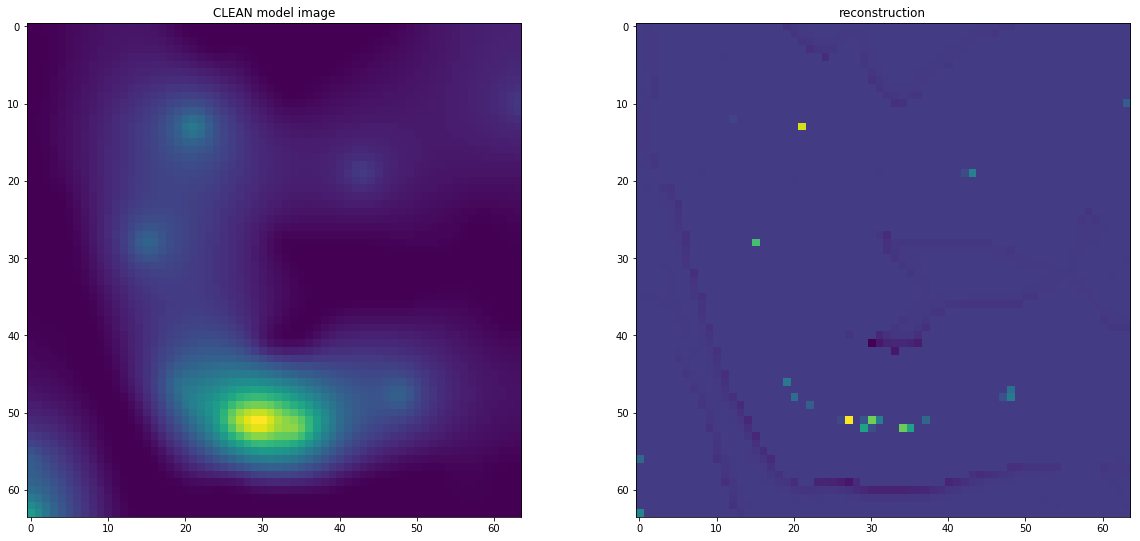

In [29]:
plot_comparison(starlet_coeff, 'CLEAN model image', starlet_coeff2, "reconstruction")

In [152]:
#starlet_0_5 = results_starlet
starlet_1_5_without = results_starlet

In [53]:
np.max(raw)

9.3351222438476

In [55]:
np.argmax(results_starlet)

2145

In [34]:
#img = np.loadtxt("./output-csv/positve_clean.csv",delimiter=',')
img = model_map.copy()
b3spline = calcSpline()

In [35]:
J = 0
M0 = calcConvMatrix(img.shape, b3spline, J)
c1 = np.reshape(np.dot(M0, img.flatten()), img.shape)
w1 = img - c1


In [140]:
J = 1
M1 = calcConvMatrix(img.shape, b3spline, J)
c2 = np.reshape(np.dot(M1, c1.flatten()), img.shape)
w2 = c1 - c2

In [65]:
J = 2
MJ = calcConvMatrix(img.shape, b3spline, J)
c3 = np.reshape(np.dot(MJ, c2.flatten()), img.shape)
w3 = c2 - c3

In [66]:
J = 3
MJ = calcConvMatrix(img.shape, b3spline, J)
c4 = np.reshape(np.dot(MJ, c3.flatten()), img.shape)
w4 = c3 - c4

In [67]:
J = 4
MJ = calcConvMatrix(img.shape, b3spline, J)
c5 = np.reshape(np.dot(MJ, c4.flatten()), img.shape)
w5 = c4 - c5

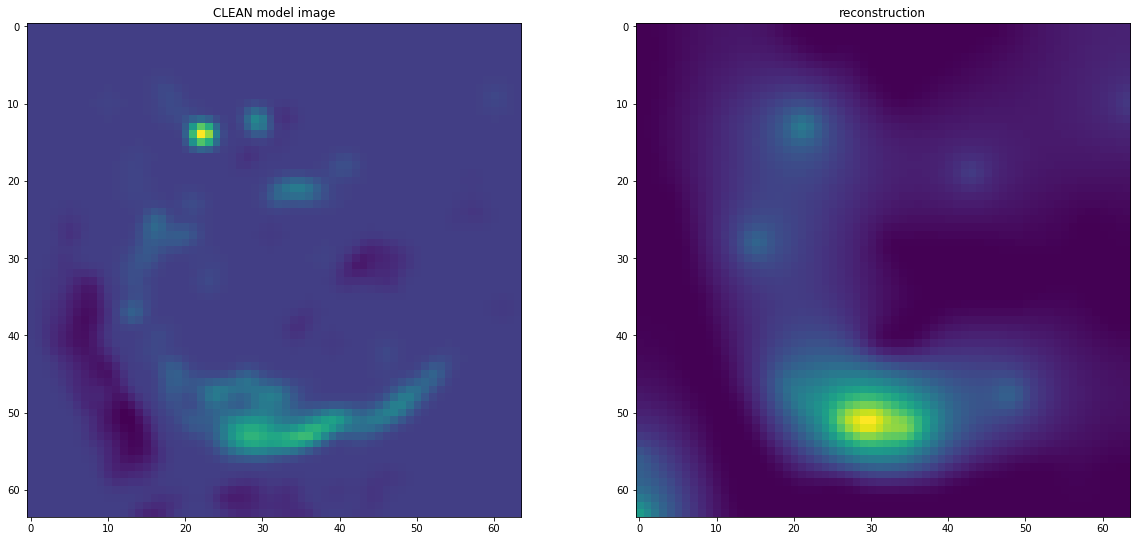

In [36]:
plot_comparison(c1, 'CLEAN model image', starlet_coeff, "reconstruction")

In [147]:
orig = c5 + w5 +w4+w3+w2+w1

1.1102230246251565e-15

In [43]:
np.absolute(w1).sum()+ np.absolute(c1).sum()

0.22274836947360654

In [44]:
np.absolute(starlet_coeff2).sum()+np.absolute(starlet_coeff).sum()

0.2465652236133179

In [45]:
res_clean = convolve2d_cutoff(model_map, psf_map)

In [59]:
clean_mse = np.mean(np.square(np.absolute(res_clean - dirty_map)))
clean_mse

2.1291840707596135e-07

In [50]:
res_star = convolve2d_cutoff(results_starlet, psf_map)

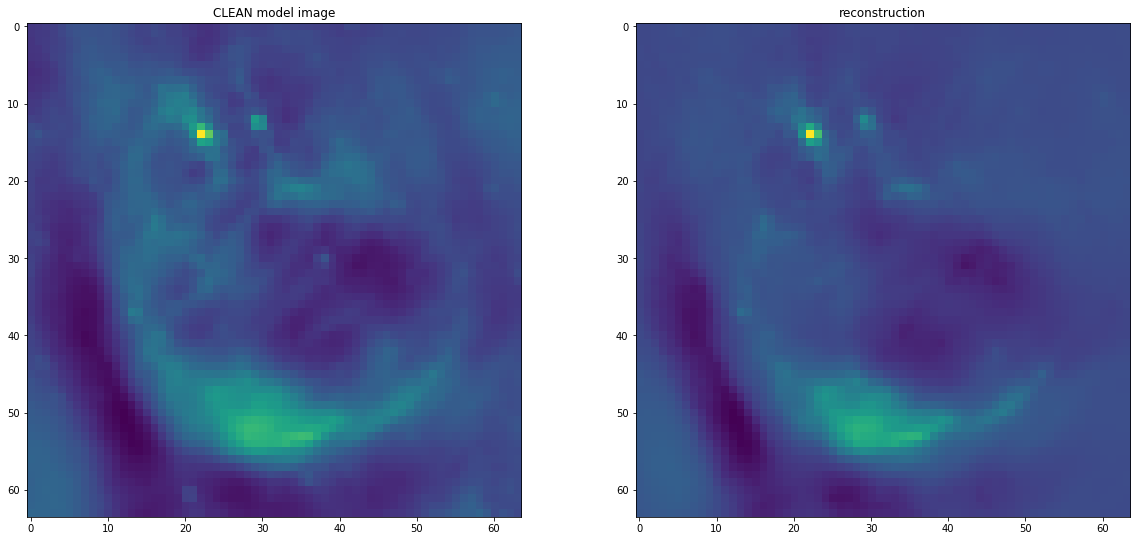

In [58]:
plot_comparison(dirty_map, 'CLEAN model image', res_clean, "reconstruction")

In [57]:
star_mse = np.mean(np.square(res_star-dirty_map))
star_mse

3.0339328796441597e-07

In [55]:
np.max(res_star)

0.003734470705036589